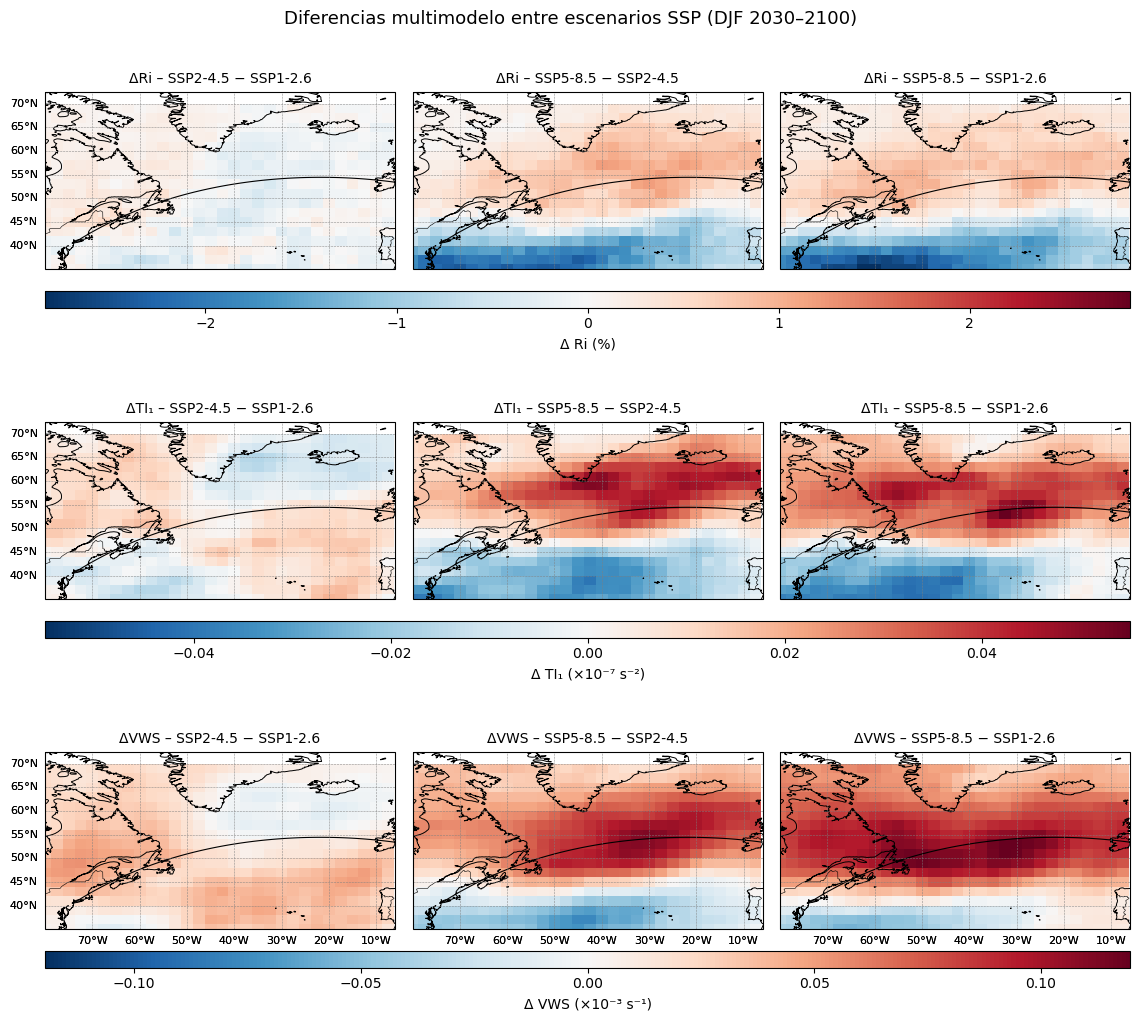

✔ Figura de diferencias absolutas guardada en:
C:/Users/jaime/Desktop/Universidad/TFG/Resultados\Diferencias_absolutas_Ri_TI1_VWS_SSP126_245_585.png


In [2]:
# COMPARACIÓN MULTIMODELO ENTRE ESCENARIOS (SSP126, SSP245 y SSP585)

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from pyproj import Geod

# CONFIGURACIÓN DE RUTAS

BASE_RESULTADOS = "C:/Users/jaime/Desktop/Universidad/TFG/Resultados"
SUBCARPETA = "CAT index"

# Carpetas de salida por escenario
base_out_126 = os.path.join(BASE_RESULTADOS, "SSP126", SUBCARPETA)
base_out_245 = os.path.join(BASE_RESULTADOS, "SSP245", SUBCARPETA)
base_out_585 = os.path.join(BASE_RESULTADOS, "SSP585", SUBCARPETA)

# CARGAR LOS ARCHIVOS MULTIMODELO GUARDADOS
Ri126 = xr.open_dataarray(os.path.join(base_out_126, "Ri_freq5_multimodelo_SSP126.nc"))
Ri245 = xr.open_dataarray(os.path.join(base_out_245, "Ri_freq5_multimodelo_SSP245.nc"))
Ri585 = xr.open_dataarray(os.path.join(base_out_585, "Ri_freq5_multimodelo_SSP585.nc"))

TI1_126 = xr.open_dataarray(os.path.join(base_out_126, "TI1_media_multimodelo_SSP126.nc"))
TI1_245 = xr.open_dataarray(os.path.join(base_out_245, "TI1_media_multimodelo_SSP245.nc"))
TI1_585 = xr.open_dataarray(os.path.join(base_out_585, "TI1_media_multimodelo_SSP585.nc"))

VWS_126 = xr.open_dataarray(os.path.join(base_out_126, "VWS_media_multimodelo_SSP126.nc"))
VWS_245 = xr.open_dataarray(os.path.join(base_out_245, "VWS_media_multimodelo_SSP245.nc"))
VWS_585 = xr.open_dataarray(os.path.join(base_out_585, "VWS_media_multimodelo_SSP585.nc"))

# Alinear rejillas (por seguridad)
Ri126, Ri245, Ri585 = xr.align(Ri126, Ri245, Ri585)
TI1_126, TI1_245, TI1_585 = xr.align(TI1_126, TI1_245, TI1_585)
VWS_126, VWS_245, VWS_585 = xr.align(VWS_126, VWS_245, VWS_585)

# CALCULAR DIFERENCIAS (filas)
# Columna 1: ΔRi (%)
Ri_diff_245_126  = Ri245 - Ri126     # Fila 1
Ri_diff_585_245  = Ri585 - Ri245     # Fila 2
Ri_diff_585_126  = Ri585 - Ri126     # Fila 3 (ahora SSP585 − SSP126)

# Columna 2: ΔTI1 (×10⁻⁷ s⁻²)
TI1_diff_245_126 = (TI1_245 - TI1_126) * 1e7
TI1_diff_585_245 = (TI1_585 - TI1_245) * 1e7
TI1_diff_585_126 = (TI1_585 - TI1_126) * 1e7

# Columna 3: ΔVWS (×10⁻³ s⁻¹)
VWS_diff_245_126 = (VWS_245 - VWS_126) * 1e3
VWS_diff_585_245 = (VWS_585 - VWS_245) * 1e3
VWS_diff_585_126 = (VWS_585 - VWS_126) * 1e3

# CONFIGURAR RUTA DUB–JFK
lon_DUB, lat_DUB = -6.2621, 53.4287   # Dublín
lon_JFK, lat_JFK = -73.7781, 40.6413  # Nueva York JFK
geod = Geod(ellps="WGS84")

# Calcular 100 puntos intermedios y añadir extremos
lons, lats = zip(*geod.npts(lon_DUB, lat_DUB, lon_JFK, lat_JFK, 100))
lons = [lon_DUB, *lons, lon_JFK]
lats = [lat_DUB, *lats, lat_JFK]

# FUNCIÓN DE PLOT GENERAL (permite pasar 'norm' común por columna)
def plot_diff(ax, data, title, cmap="RdBu_r", norm=None):
    """Gráfico con escala centrada en 0; si se pasa 'norm', se usa tal cual."""
    if norm is None:
        lim = np.nanmax(np.abs(data))
        norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-lim, vmax=lim)
    im = data.plot(ax=ax, transform=ccrs.PlateCarree(),
                   cmap=cmap, norm=norm, add_colorbar=False)
    ax.set_title(title, fontsize=10)
    ax.coastlines(linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_extent([280, 354, 35, 69])
    ax.plot(lons, lats, transform=ccrs.Geodetic(),
            color="black", linewidth=0.8)
    return im

# Normalizaciones por columna (mismo rango en las 3 filas)
# Columna Ri
lim_Ri = np.nanmax(np.abs(xr.concat([Ri_diff_245_126, Ri_diff_585_245, Ri_diff_585_126], dim="stack")))
norm_Ri = mcolors.TwoSlopeNorm(vcenter=0, vmin=-lim_Ri, vmax=lim_Ri)
# Columna TI1
lim_TI1 = np.nanmax(np.abs(xr.concat([TI1_diff_245_126, TI1_diff_585_245, TI1_diff_585_126], dim="stack")))
norm_TI1 = mcolors.TwoSlopeNorm(vcenter=0, vmin=-lim_TI1, vmax=lim_TI1)
# Columna VWS
lim_VWS = np.nanmax(np.abs(xr.concat([VWS_diff_245_126, VWS_diff_585_245, VWS_diff_585_126], dim="stack")))
norm_VWS = mcolors.TwoSlopeNorm(vcenter=0, vmin=-lim_VWS, vmax=lim_VWS)

# FIGURA CON 9 SUBPLOTS (3 filas × 3 columnas)
fig, axes = plt.subplots(3, 3, figsize=(14, 11),
                         subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.05, hspace=0.25, top=0.95)

# Organización por variable (filas) y diferencia (columnas)

# Fila 1: Ri
im11 = plot_diff(axes[0,0], Ri_diff_245_126, "ΔRi – SSP2-4.5 − SSP1-2.6", norm=norm_Ri)
im12 = plot_diff(axes[0,1], Ri_diff_585_245, "ΔRi – SSP5-8.5 − SSP2-4.5", norm=norm_Ri)
im13 = plot_diff(axes[0,2], Ri_diff_585_126, "ΔRi – SSP5-8.5 − SSP1-2.6", norm=norm_Ri)

# Fila 2: TI₁
im21 = plot_diff(axes[1,0], TI1_diff_245_126, "ΔTI₁ – SSP2-4.5 − SSP1-2.6", norm=norm_TI1)
im22 = plot_diff(axes[1,1], TI1_diff_585_245, "ΔTI₁ – SSP5-8.5 − SSP2-4.5", norm=norm_TI1)
im23 = plot_diff(axes[1,2], TI1_diff_585_126, "ΔTI₁ – SSP5-8.5 − SSP1-2.6", norm=norm_TI1)

# Fila 3: VWS
im31 = plot_diff(axes[2,0], VWS_diff_245_126, "ΔVWS – SSP2-4.5 − SSP1-2.6", norm=norm_VWS)
im32 = plot_diff(axes[2,1], VWS_diff_585_245, "ΔVWS – SSP5-8.5 − SSP2-4.5", norm=norm_VWS)
im33 = plot_diff(axes[2,2], VWS_diff_585_126, "ΔVWS – SSP5-8.5 − SSP1-2.6", norm=norm_VWS)

# Barras de color: una por fila, debajo de sus tres paneles
row_ims = [
    ([im11, im12, im13], "Δ Ri (%)"),
    ([im21, im22, im23], "Δ TI₁ (×10⁻⁷ s⁻²)"),
    ([im31, im32, im33], "Δ VWS (×10⁻³ s⁻¹)")
]

for i, (ims_row, label) in enumerate(row_ims):
    pos = [axes[i, j].get_position() for j in range(3)]
    x0 = pos[0].x0
    x1 = pos[-1].x1
    y0 = pos[-1].y0 - 0.035  # posición vertical debajo de la fila
    cbar_ax = fig.add_axes([x0, y0, x1 - x0, 0.015])
    cbar = fig.colorbar(ims_row[0], cax=cbar_ax, orientation="horizontal")
    cbar.set_label(label)

# Etiquetas de latitud/longitud (igual que antes)
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 8}
        gl.ylabel_style = {"size": 8}
        gl.bottom_labels = (i == 2)
        gl.left_labels = (j == 0)

# Etiquetas de latitud/longitud
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 8}
        gl.ylabel_style = {"size": 8}
        gl.bottom_labels = (i == 2)   # longitudes solo en la última fila
        gl.left_labels = (j == 0)     # latitudes solo en la primera columna

# Título y guardado
plt.suptitle("Diferencias multimodelo entre escenarios SSP (DJF 2030–2100)",
             fontsize=13, y=0.985)

salida = os.path.join(BASE_RESULTADOS, "Diferencias_absolutas_Ri_TI1_VWS_SSP126_245_585.png")
plt.savefig(salida, dpi=300, bbox_inches="tight")
plt.show()

print(f"Figura de diferencias absolutas guardada en:\n{salida}")


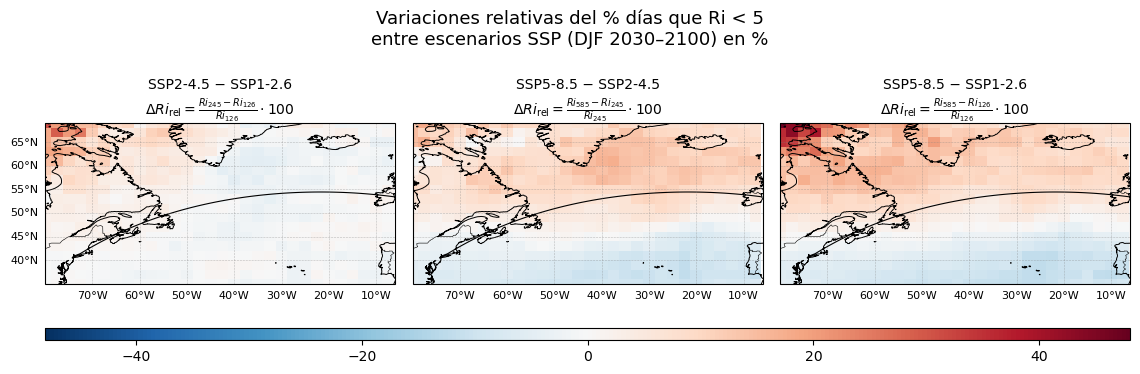

✔ Figura de diferencias relativas de Ri guardada en:
C:/Users/jaime/Desktop/Universidad/TFG/Resultados\Comparacion_Ri_relativa_SSP126_245_585.png


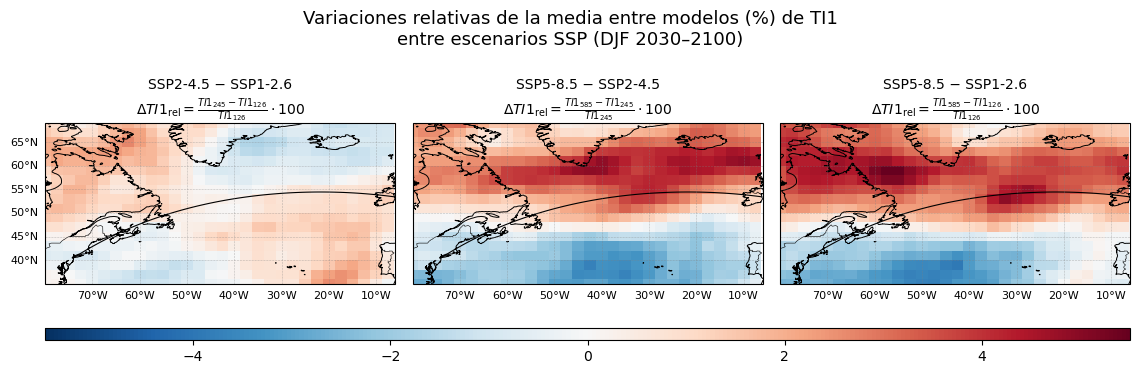

✔ Figura de diferencias relativas de TI1 guardada en:
C:/Users/jaime/Desktop/Universidad/TFG/Resultados\Comparacion_TI1_relativa_SSP126_245_585.png


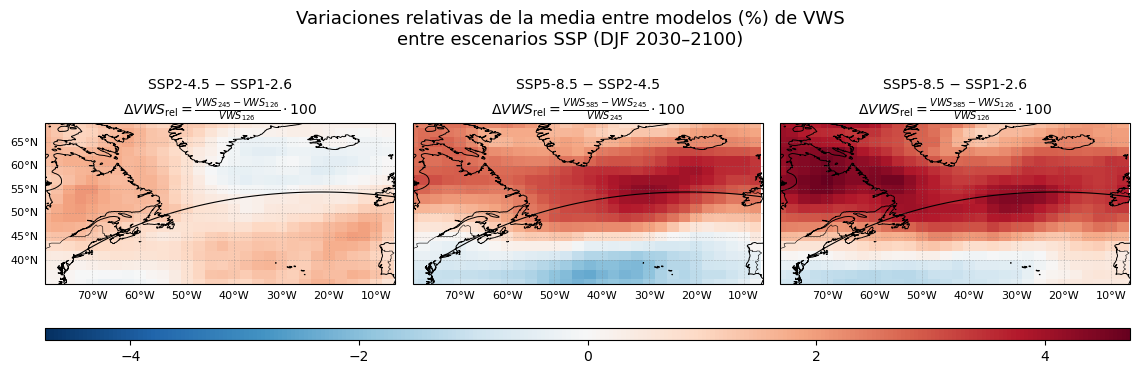

✔ Figura de diferencias relativas de VWS guardada en:
C:/Users/jaime/Desktop/Universidad/TFG/Resultados\Comparacion_VWS_relativa_SSP126_245_585.png


In [3]:
# FIGURA: DIFERENCIAS RELATIVAS (%) ENTRE ESCENARIOS SSP
# Calcular diferencias relativas (%)
# (ΔX / X_ref) * 100
Ri_diff_rel_245_126  = 100 * (Ri245 - Ri126) / Ri126
Ri_diff_rel_585_245  = 100 * (Ri585 - Ri245) / Ri245
Ri_diff_rel_585_126  = 100 * (Ri585 - Ri126) / Ri126

TI1_diff_rel_245_126 = 100 * (TI1_245 - TI1_126) / TI1_126
TI1_diff_rel_585_245 = 100 * (TI1_585 - TI1_245) / TI1_245
TI1_diff_rel_585_126 = 100 * (TI1_585 - TI1_126) / TI1_126

VWS_diff_rel_245_126 = 100 * (VWS_245 - VWS_126) / VWS_126
VWS_diff_rel_585_245 = 100 * (VWS_585 - VWS_245) / VWS_245
VWS_diff_rel_585_126 = 100 * (VWS_585 - VWS_126) / VWS_126

# Eliminar valores extremos absurdos (p. ej. >200%)
for var in [
    Ri_diff_rel_245_126, Ri_diff_rel_585_245, Ri_diff_rel_585_126,
    TI1_diff_rel_245_126, TI1_diff_rel_585_245, TI1_diff_rel_585_126,
    VWS_diff_rel_245_126, VWS_diff_rel_585_245, VWS_diff_rel_585_126
]:
    var[:] = var.where(np.abs(var) < 200)

# Normalizaciones por fila (mismo rango en las 3 columnas)
# Fila Ri
lim_Ri_rel = np.nanmax(np.abs(xr.concat(
    [Ri_diff_rel_245_126, Ri_diff_rel_585_245, Ri_diff_rel_585_126], dim="stack")))
norm_Ri_rel = mcolors.TwoSlopeNorm(vcenter=0, vmin=-lim_Ri_rel, vmax=lim_Ri_rel)

# Fila TI1
lim_TI1_rel = np.nanmax(np.abs(xr.concat(
    [TI1_diff_rel_245_126, TI1_diff_rel_585_245, TI1_diff_rel_585_126], dim="stack")))
norm_TI1_rel = mcolors.TwoSlopeNorm(vcenter=0, vmin=-lim_TI1_rel, vmax=lim_TI1_rel)

# Fila VWS
lim_VWS_rel = np.nanmax(np.abs(xr.concat(
    [VWS_diff_rel_245_126, VWS_diff_rel_585_245, VWS_diff_rel_585_126], dim="stack")))
norm_VWS_rel = mcolors.TwoSlopeNorm(vcenter=0, vmin=-lim_VWS_rel, vmax=lim_VWS_rel)

# FIGURA 1: ΔRi relativo (%)

fig_ri, axes_ri = plt.subplots(1, 3, figsize=(14, 4),
                               subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.05, hspace=0.18)

im11 = plot_diff(axes_ri[0], Ri_diff_rel_245_126, "SSP2-4.5 − SSP1-2.6\n" r"$\Delta Ri_{\mathrm{rel}} = \frac{Ri_{245}-Ri_{126}}{Ri_{126}}\cdot 100$",
                 norm=norm_Ri_rel)
im12 = plot_diff(axes_ri[1], Ri_diff_rel_585_245, "SSP5-8.5 − SSP2-4.5\n" r"$\Delta Ri_{\mathrm{rel}} = \frac{Ri_{585}-Ri_{245}}{Ri_{245}}\cdot 100$",
                 norm=norm_Ri_rel)
im13 = plot_diff(axes_ri[2], Ri_diff_rel_585_126, "SSP5-8.5 − SSP1-2.6\n" r"$\Delta Ri_{\mathrm{rel}} = \frac{Ri_{585}-Ri_{126}}{Ri_{126}}\cdot 100$", 
                 norm=norm_Ri_rel)

# Barra de color para Ri
pos = [ax.get_position() for ax in axes_ri]
x0 = pos[0].x0
x1 = pos[-1].x1
y0 = pos[-1].y0 - 0.12
cbar_ax = fig_ri.add_axes([x0, y0, x1 - x0, 0.03])
cbar = fig_ri.colorbar(im11, cax=cbar_ax, orientation="horizontal")

# Gridlines para Ri
for j in range(3):
    ax = axes_ri[j]
    ax.set_extent([280, 354, 35, 69], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    gl.bottom_labels = True        # solo una fila
    gl.left_labels = (j == 0)      # solo primera columna

fig_ri.suptitle("Variaciones relativas del % días que Ri < 5\nentre escenarios SSP (DJF 2030–2100) en %",
                fontsize=13, y=0.98)

salida_ri = os.path.join(BASE_RESULTADOS, "Comparacion_Ri_relativa_SSP126_245_585.png")
fig_ri.savefig(salida_ri, dpi=300, bbox_inches="tight")
plt.show()
print(f"Figura de diferencias relativas de Ri guardada en:\n{salida_ri}")

# FIGURA 2: ΔTI1 relativo (%)

fig_ti1, axes_ti1 = plt.subplots(1, 3, figsize=(14, 4),
                                 subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.05, hspace=0.18)

im21 = plot_diff(axes_ti1[0], TI1_diff_rel_245_126, "SSP2-4.5 − SSP1-2.6\n" r"$\Delta TI1_{\mathrm{rel}} = \frac{TI1_{245}-TI1_{126}}{TI1_{126}}\cdot 100$", 
                 norm=norm_TI1_rel)
im22 = plot_diff(axes_ti1[1], TI1_diff_rel_585_245, "SSP5-8.5 − SSP2-4.5\n" r"$\Delta TI1_{\mathrm{rel}} = \frac{TI1_{585}-TI1_{245}}{TI1_{245}}\cdot 100$", 
                 norm=norm_TI1_rel)
im23 = plot_diff(axes_ti1[2], TI1_diff_rel_585_126, "SSP5-8.5 − SSP1-2.6\n" r"$\Delta TI1_{\mathrm{rel}} = \frac{TI1_{585}-TI1_{126}}{TI1_{126}}\cdot 100$", 
                 norm=norm_TI1_rel)


# Barra de color para TI1
pos = [ax.get_position() for ax in axes_ti1]
x0 = pos[0].x0
x1 = pos[-1].x1
y0 = pos[-1].y0 - 0.12
cbar_ax = fig_ti1.add_axes([x0, y0, x1 - x0, 0.03])
cbar = fig_ti1.colorbar(im21, cax=cbar_ax, orientation="horizontal")

# Gridlines para TI1
for j in range(3):
    ax = axes_ti1[j]
    ax.set_extent([280, 354, 35, 69], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    gl.bottom_labels = True
    gl.left_labels = (j == 0)

fig_ti1.suptitle("Variaciones relativas de la media entre modelos (%) de TI1\nentre escenarios SSP (DJF 2030–2100)",
                 fontsize=13, y=0.98)

salida_ti1 = os.path.join(BASE_RESULTADOS, "Comparacion_TI1_relativa_SSP126_245_585.png")
fig_ti1.savefig(salida_ti1, dpi=300, bbox_inches="tight")
plt.show()
print(f"Figura de diferencias relativas de TI1 guardada en:\n{salida_ti1}")


# FIGURA 3: ΔVWS relativo (%)
fig_vws, axes_vws = plt.subplots(1, 3, figsize=(14, 4),
                                 subplot_kw={"projection": ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.05, hspace=0.18)

im31 = plot_diff(axes_vws[0], VWS_diff_rel_245_126, "SSP2-4.5 − SSP1-2.6\n" r"$\Delta VWS_{\mathrm{rel}} = \frac{VWS_{245}-VWS_{126}}{VWS_{126}}\cdot 100$", 
                 norm=norm_VWS_rel)
im32 = plot_diff(axes_vws[1], VWS_diff_rel_585_245, "SSP5-8.5 − SSP2-4.5\n" r"$\Delta VWS_{\mathrm{rel}} = \frac{VWS_{585}-VWS_{245}}{VWS_{245}}\cdot 100$", norm=norm_VWS_rel)
im33 = plot_diff(axes_vws[2], VWS_diff_rel_585_126, "SSP5-8.5 − SSP1-2.6\n" r"$\Delta VWS_{\mathrm{rel}} = \frac{VWS_{585}-VWS_{126}}{VWS_{126}}\cdot 100$", norm=norm_VWS_rel)

# Barra de color para VWS
pos = [ax.get_position() for ax in axes_vws]
x0 = pos[0].x0
x1 = pos[-1].x1
y0 = pos[-1].y0 - 0.12
cbar_ax = fig_vws.add_axes([x0, y0, x1 - x0, 0.03])
cbar = fig_vws.colorbar(im31, cax=cbar_ax, orientation="horizontal")

# Gridlines para VWS
for j in range(3):
    ax = axes_vws[j]
    ax.set_extent([280, 354, 35, 69], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    gl.bottom_labels = True
    gl.left_labels = (j == 0)

fig_vws.suptitle("Variaciones relativas de la media entre modelos (%) de VWS\nentre escenarios SSP (DJF 2030–2100)",
                 fontsize=13, y=0.98)

salida_vws = os.path.join(BASE_RESULTADOS, "Comparacion_VWS_relativa_SSP126_245_585.png")
fig_vws.savefig(salida_vws, dpi=300, bbox_inches="tight")
plt.show()
print(f"Figura de diferencias relativas de VWS guardada en:\n{salida_vws}")


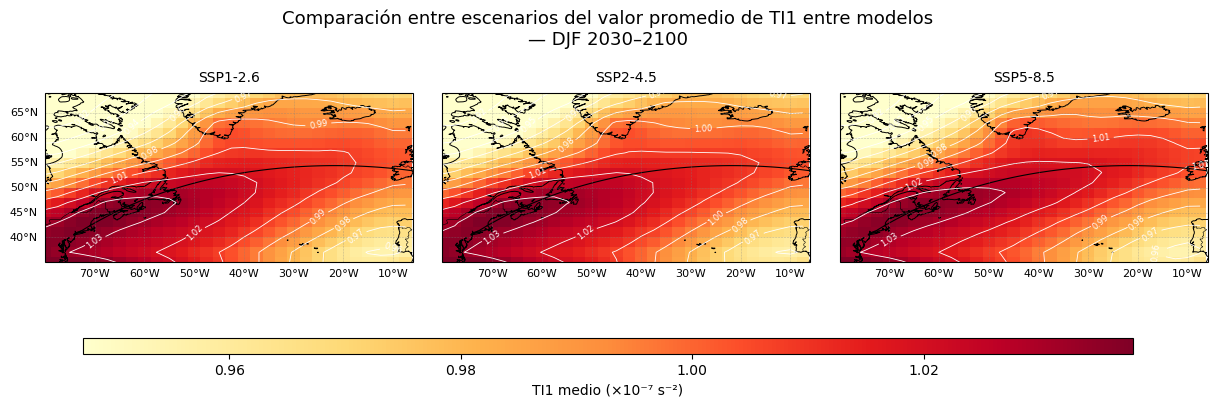

✔ Figura TI₁ guardada en:
C:\Users\jaime\Desktop\Universidad\TFG\Resultados\Comparaciones\Comparacion_TI1_SSP126_245_585.png


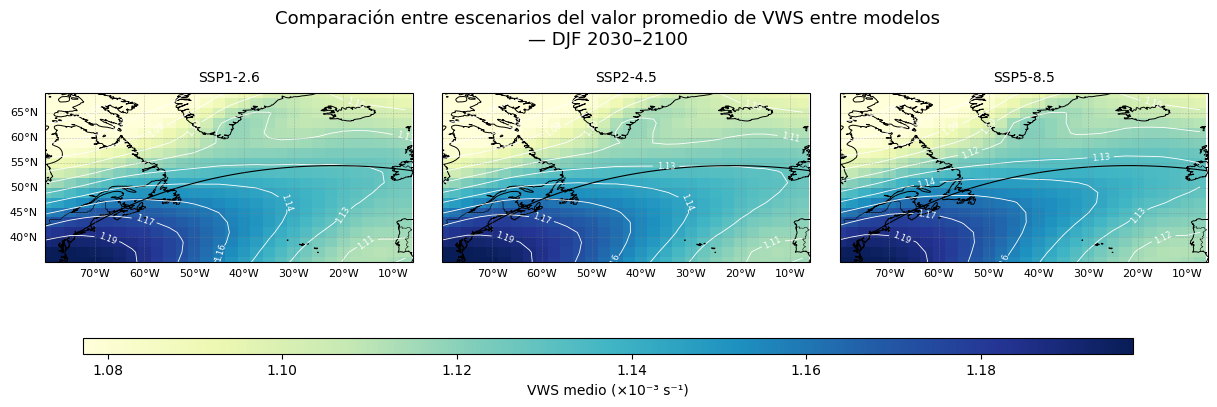

✔ Figura VWS guardada en:
C:\Users\jaime\Desktop\Universidad\TFG\Resultados\Comparaciones\Comparacion_VWS_SSP126_245_585.png


In [3]:
# PANEL COMPARATIVO POR ESCENARIO (añadida columna SSP1-2.6)
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Carpeta de salida
out_dir = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados\Comparaciones"
os.makedirs(out_dir, exist_ok=True)

# Escalas pseudo-logarítmicas (raíz cúbica) más suaves
# TI₁
ti1_126_scaled = TI1_126 * 1e7
ti1_245_scaled = TI1_245 * 1e7
ti1_585_scaled = TI1_585 * 1e7

# Evitar negativos o ceros
ti1_126_pos = xr.where(ti1_126_scaled > 0, ti1_126_scaled, 0)
ti1_245_pos = xr.where(ti1_245_scaled > 0, ti1_245_scaled, 0)
ti1_585_pos = xr.where(ti1_585_scaled > 0, ti1_585_scaled, 0)

# Aplicar raíz cúbica (más perceptual)
ti1_126_cubic = ti1_126_pos ** (1/8)
ti1_245_cubic = ti1_245_pos ** (1/8)
ti1_585_cubic = ti1_585_pos ** (1/8)

# Definir límites robustos después de la transformación
ti1_vmin = float(xr.concat([ti1_126_cubic, ti1_245_cubic, ti1_585_cubic], dim="merge").quantile(0.10))
ti1_vmax = float(xr.concat([ti1_126_cubic, ti1_245_cubic, ti1_585_cubic], dim="merge").quantile(0.99))
ti1_norm = mcolors.Normalize(vmin=ti1_vmin, vmax=ti1_vmax)

# VWS
vws_126_scaled = VWS_126 * 1e3
vws_245_scaled = VWS_245 * 1e3
vws_585_scaled = VWS_585 * 1e3

vws_126_pos = xr.where(vws_126_scaled > 0, vws_126_scaled, 0)
vws_245_pos = xr.where(vws_245_scaled > 0, vws_245_scaled, 0)
vws_585_pos = xr.where(vws_585_scaled > 0, vws_585_scaled, 0)

vws_126_cubic = vws_126_pos ** (1/8)
vws_245_cubic = vws_245_pos ** (1/8)
vws_585_cubic = vws_585_pos ** (1/8)

vws_vmin = float(xr.concat([vws_126_cubic, vws_245_cubic, vws_585_cubic], dim="merge").quantile(0.10))
vws_vmax = float(xr.concat([vws_126_cubic, vws_245_cubic, vws_585_cubic], dim="merge").quantile(0.99))
vws_norm = mcolors.Normalize(vmin=vws_vmin, vmax=vws_vmax)

# FUNCIÓN PARA DIBUJAR MAPAS
def draw_map(ax, da, title, norm, cmap="YlOrRd", show_left=False, show_bottom=False):
    im = da.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=cmap, norm=norm, add_colorbar=False
    )

    n_contours = 12
    levels = np.linspace(float(da.min()), float(da.max()), n_contours)
    cs = ax.contour(
        da.lon, da.lat, da,
        levels=levels, colors="white", linewidths=0.6,
        transform=ccrs.PlateCarree()
    )

    ax.clabel(cs, fmt="%.2f", fontsize=6, colors="white", inline=True, inline_spacing=3)
    ax.set_title(title, fontsize=10, pad=8)
    ax.coastlines(linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_extent([280, 354, 35, 69], crs=ccrs.PlateCarree())

    # Ruta DUB–JFK (opcional)
    ax.plot(lons, lats, transform=ccrs.Geodetic(), color="black", linewidth=0.8)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = show_left
    gl.bottom_labels = show_bottom
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return im

# FIGURA 1 — TI₁ (3 paneles)
fig_ti1, axes_ti1 = plt.subplots(
    1, 3, figsize=(15, 4),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
(ax_ti1_126, ax_ti1_245, ax_ti1_585) = axes_ti1

im_ti1_126 = draw_map(ax_ti1_126, ti1_126_cubic, "SSP1-2.6",
                      ti1_norm, cmap="YlOrRd", show_left=True, show_bottom=True)
im_ti1_245 = draw_map(ax_ti1_245, ti1_245_cubic, "SSP2-4.5",
                      ti1_norm, cmap="YlOrRd", show_left=False, show_bottom=True)
im_ti1_585 = draw_map(ax_ti1_585, ti1_585_cubic, "SSP5-8.5",
                      ti1_norm, cmap="YlOrRd", show_left=False, show_bottom=True)

# Barra de color TI₁
cbar_ax1 = fig_ti1.add_axes([0.15, 0.1, 0.7, 0.04])
cbar1 = fig_ti1.colorbar(plt.cm.ScalarMappable(norm=ti1_norm, cmap="YlOrRd"),
                         cax=cbar_ax1, orientation="horizontal")
cbar1.set_label("TI1 medio (×10⁻⁷ s⁻²)")

fig_ti1.suptitle("Comparación entre escenarios del valor promedio de TI1 entre modelos\n— DJF 2030–2100", fontsize=13, y=0.96)
plt.subplots_adjust(top=0.90, bottom=0.18, wspace=0.08)
out_ti1 = os.path.join(out_dir, "Comparacion_TI1_SSP126_245_585.png")
fig_ti1.savefig(out_ti1, dpi=300, bbox_inches="tight")
plt.show()
print(f"Figura TI₁ guardada en:\n{out_ti1}")

# FIGURA 2 — VWS (3 paneles)
fig_vws, axes_vws = plt.subplots(
    1, 3, figsize=(15, 4),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
(ax_vws_126, ax_vws_245, ax_vws_585) = axes_vws

im_vws_126 = draw_map(ax_vws_126, vws_126_cubic, "SSP1-2.6",
                      vws_norm, cmap="YlGnBu", show_left=True, show_bottom=True)
im_vws_245 = draw_map(ax_vws_245, vws_245_cubic, "SSP2-4.5",
                      vws_norm, cmap="YlGnBu", show_left=False, show_bottom=True)
im_vws_585 = draw_map(ax_vws_585, vws_585_cubic, "SSP5-8.5",
                      vws_norm, cmap="YlGnBu", show_left=False, show_bottom=True)

# Barra de color VWS
cbar_ax2 = fig_vws.add_axes([0.15, 0.1, 0.7, 0.04])
cbar2 = fig_vws.colorbar(plt.cm.ScalarMappable(norm=vws_norm, cmap="YlGnBu"),
                         cax=cbar_ax2, orientation="horizontal")
cbar2.set_label("VWS medio (×10⁻³ s⁻¹)")

fig_vws.suptitle("Comparación entre escenarios del valor promedio de VWS entre modelos\n— DJF 2030–2100", fontsize=13, y=0.96)
plt.subplots_adjust(top=0.90, bottom=0.18, wspace=0.08)
out_vws = os.path.join(out_dir, "Comparacion_VWS_SSP126_245_585.png")
fig_vws.savefig(out_vws, dpi=300, bbox_inches="tight")
plt.show()
print(f"Figura VWS guardada en:\n{out_vws}")


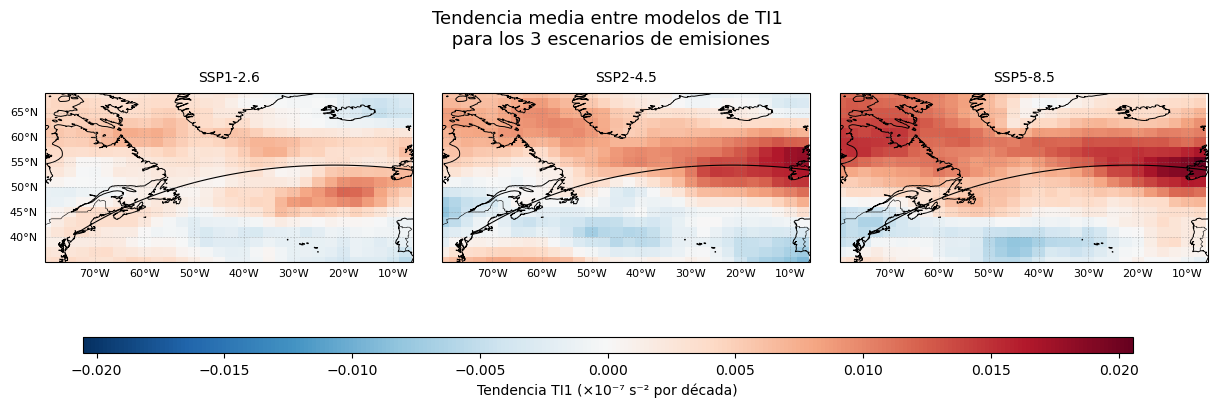

✔ Figura TI₁ (tendencias) guardada en:
C:\Users\jaime\Desktop\Universidad\TFG\Resultados\Comparaciones\Tendencia_TI1_SSP126_245_585.png


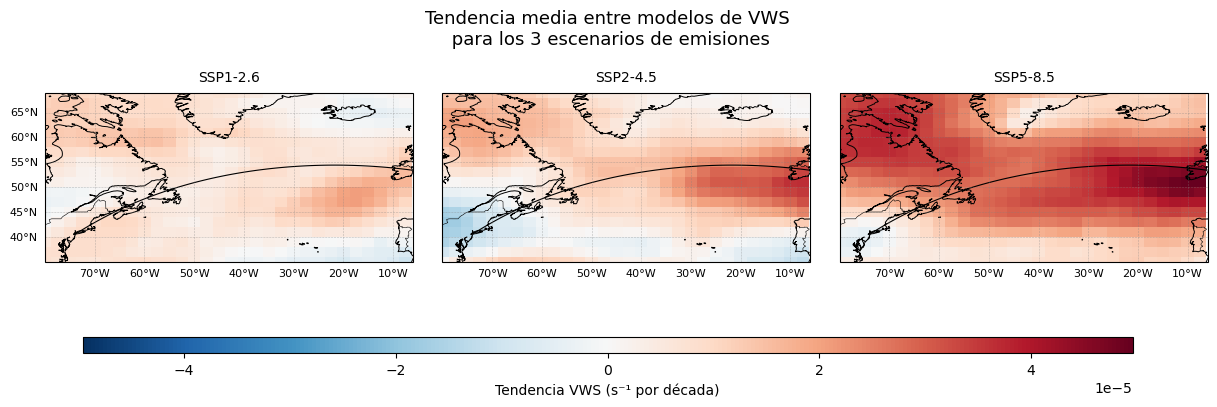

✔ Figura VWS (tendencias) guardada en:
C:\Users\jaime\Desktop\Universidad\TFG\Resultados\Comparaciones\Tendencia_VWS_SSP126_245_585.png


In [12]:
# PANEL COMPARATIVO DE TENDENCIAS (separado en dos figuras)
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Carpeta de salida
out_dir = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados\Comparaciones"
os.makedirs(out_dir, exist_ok=True)

# CARGA DE DATOS (rutas actualizadas)
base_resultados = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados"

ti1_tend_126 = xr.open_dataarray(os.path.join(base_resultados, "SSP126", "CAT index", "TI1_tendencia_multimodelo_SSP126.nc"))
ti1_tend_245 = xr.open_dataarray(os.path.join(base_resultados, "SSP245", "CAT index", "TI1_tendencia_multimodelo_SSP245.nc"))
ti1_tend_585 = xr.open_dataarray(os.path.join(base_resultados, "SSP585", "CAT index", "TI1_tendencia_multimodelo_SSP585.nc"))

vws_tend_126 = xr.open_dataarray(os.path.join(base_resultados, "SSP126", "CAT index", "VWS_tendencia_multimodelo_SSP126.nc"))
vws_tend_245 = xr.open_dataarray(os.path.join(base_resultados, "SSP245", "CAT index", "VWS_tendencia_multimodelo_SSP245.nc"))
vws_tend_585 = xr.open_dataarray(os.path.join(base_resultados, "SSP585", "CAT index", "VWS_tendencia_multimodelo_SSP585.nc"))

# Escalas simétricas comunes (entre los tres escenarios)
ti1_triplet = xr.concat([ti1_tend_126 * 1e7, ti1_tend_245 * 1e7, ti1_tend_585 * 1e7], dim="merge")
vws_triplet = xr.concat([vws_tend_126, vws_tend_245, vws_tend_585], dim="merge")  # VWS ya en s⁻¹ por década

ti1_lim = float(np.nanmax(np.abs(ti1_triplet)))
vws_lim = float(np.nanmax(np.abs(vws_triplet)))

ti1_norm = mcolors.TwoSlopeNorm(vmin=-ti1_lim, vcenter=0, vmax=ti1_lim)
vws_norm = mcolors.TwoSlopeNorm(vmin=-vws_lim, vcenter=0, vmax=vws_lim)

# FUNCIÓN PARA DIBUJAR MAPAS DE TENDENCIAS
def draw_trend(ax, da, title, norm, cmap="RdBu_r", show_left=False, show_bottom=False):
    im = (da).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=cmap, norm=norm, add_colorbar=False
    )
    ax.set_title(title, fontsize=10, pad=8)
    ax.coastlines(linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_extent([280, 354, 35, 69], crs=ccrs.PlateCarree())
    ax.plot(lons, lats, transform=ccrs.Geodetic(), color="black", linewidth=0.8)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = show_left
    gl.bottom_labels = show_bottom
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return im

# FIGURA 1 — TENDENCIAS TI₁
fig_ti1, axes_ti1 = plt.subplots(
    1, 3, figsize=(15, 4),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
(ax_ti1_126, ax_ti1_245, ax_ti1_585) = axes_ti1

draw_trend(ax_ti1_126, ti1_tend_126 * 1e7, "SSP1-2.6",
           ti1_norm, show_left=True, show_bottom=True)
draw_trend(ax_ti1_245, ti1_tend_245 * 1e7, "SSP2-4.5",
           ti1_norm, show_left=False, show_bottom=True)
draw_trend(ax_ti1_585, ti1_tend_585 * 1e7, "SSP5-8.5",
           ti1_norm, show_left=False, show_bottom=True)

# Barra de color TI₁
cbar_ax1 = fig_ti1.add_axes([0.15, 0.1, 0.7, 0.04])
cbar1 = fig_ti1.colorbar(plt.cm.ScalarMappable(norm=ti1_norm, cmap="RdBu_r"),
                         cax=cbar_ax1, orientation="horizontal")
cbar1.set_label("Tendencia TI1 (×10⁻⁷ s⁻² por década)")

fig_ti1.suptitle("Tendencia media entre modelos de TI1\n para los 3 escenarios de emisiones", fontsize=13, y=0.96)
plt.subplots_adjust(top=0.90, bottom=0.18, wspace=0.08)
out_ti1 = os.path.join(out_dir, "Tendencia_TI1_SSP126_245_585.png")
fig_ti1.savefig(out_ti1, dpi=300, bbox_inches="tight")
plt.show()
print(f"Figura TI₁ (tendencias) guardada en:\n{out_ti1}")

# FIGURA 2 — TENDENCIAS VWS
fig_vws, axes_vws = plt.subplots(
    1, 3, figsize=(15, 4),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
(ax_vws_126, ax_vws_245, ax_vws_585) = axes_vws

draw_trend(ax_vws_126, vws_tend_126, "SSP1-2.6",
           vws_norm, show_left=True, show_bottom=True)
draw_trend(ax_vws_245, vws_tend_245, "SSP2-4.5",
           vws_norm, show_left=False, show_bottom=True)
draw_trend(ax_vws_585, vws_tend_585, "SSP5-8.5",
           vws_norm, show_left=False, show_bottom=True)

# Barra de color VWS
cbar_ax2 = fig_vws.add_axes([0.15, 0.1, 0.7, 0.04])
cbar2 = fig_vws.colorbar(plt.cm.ScalarMappable(norm=vws_norm, cmap="RdBu_r"),
                         cax=cbar_ax2, orientation="horizontal")
cbar2.set_label("Tendencia VWS (s⁻¹ por década)")

fig_vws.suptitle("Tendencia media entre modelos de VWS\n para los 3 escenarios de emisiones", fontsize=13, y=0.96)
plt.subplots_adjust(top=0.90, bottom=0.18, wspace=0.08)
out_vws = os.path.join(out_dir, "Tendencia_VWS_SSP126_245_585.png")
fig_vws.savefig(out_vws, dpi=300, bbox_inches="tight")
plt.show()
print(f"Figura VWS (tendencias) guardada en:\n{out_vws}")


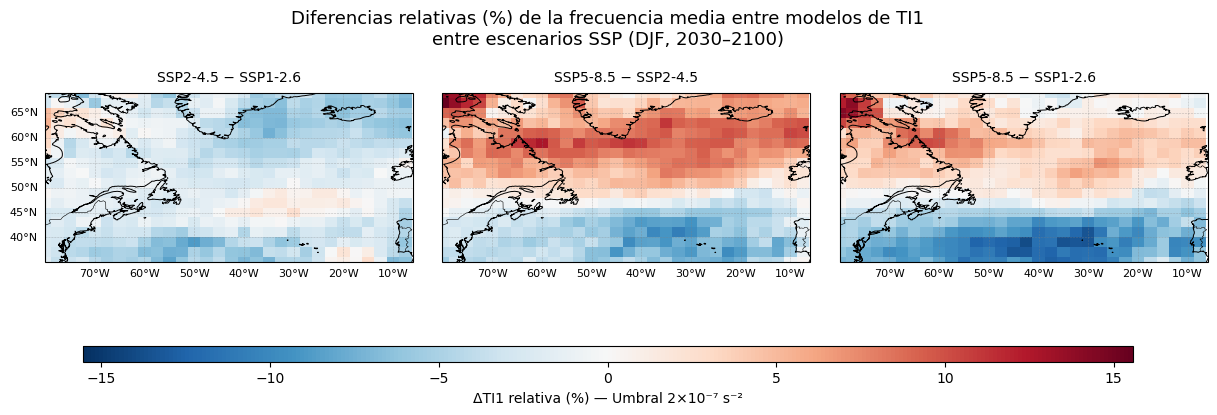

✔ Figura de diferencias relativas de TI1 guardada en:
C:\Users\jaime\Desktop\Universidad\TFG\Resultados\Comparaciones\Frecuencia_TI1_dif_rel_umbral2e7_SSP126_245_585.png


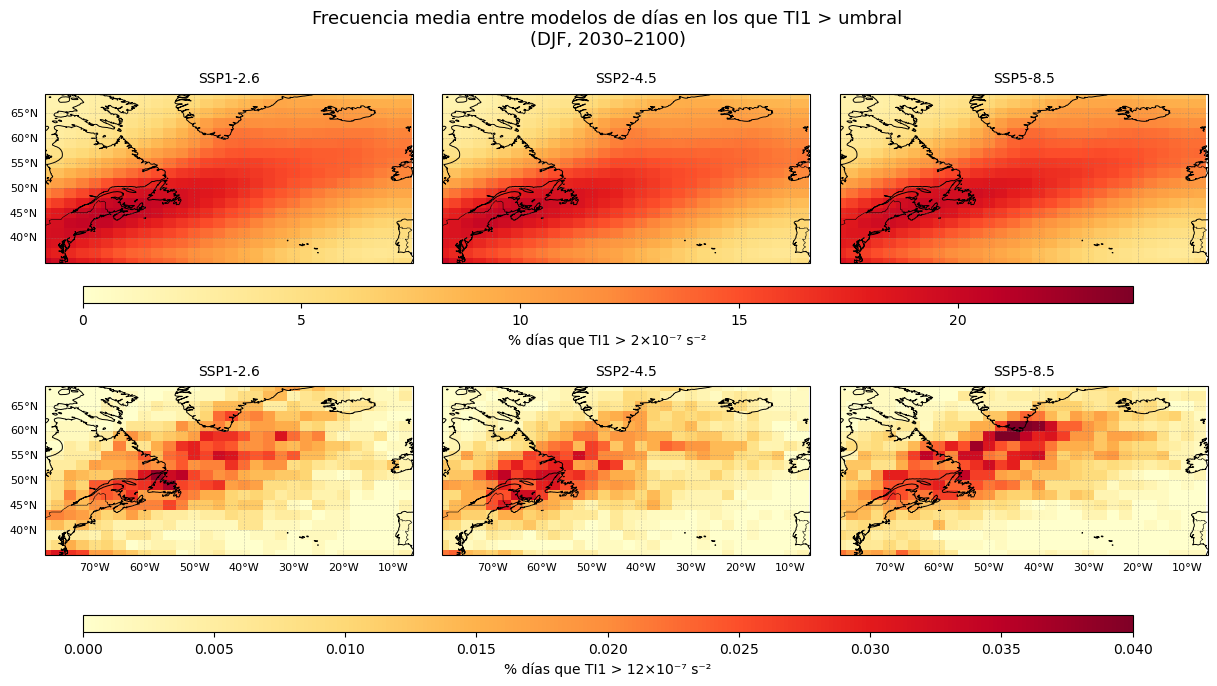

✔ Figura de frecuencias guardada en:
C:\Users\jaime\Desktop\Universidad\TFG\Resultados\Comparaciones\Frecuencia_TI1_2umbrales_SSP126_245_585.png


In [6]:
# PANEL COMPARATIVO DE FRECUENCIAS DE TI1
#  Fila 1: umbral 2×10⁻⁷
#  Fila 2: umbral 1.2×10⁻⁶
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Carpeta de salida
out_dir = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados\Comparaciones"
os.makedirs(out_dir, exist_ok=True)

# CARGA DE DATOS (rutas actualizadas)
base_resultados = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados"

# Umbrales (solo para etiquetas)
umbral_bajo = 2e-7
umbral_alto = 1.2e-6

# Archivos: asumo estos nombres exactos para cada escenario y umbral
def load_freq(escenario, sufijo_umbral):
    ruta = os.path.join(
        base_resultados, escenario, "CAT index", "por_modelo",
        f"TI1_frecuencia_por_modelo_{escenario}_{sufijo_umbral}.nc"
    )
    return xr.open_dataarray(ruta)

# FUNCIÓN PARA DIBUJAR MAPAS (frecuencias o diferencias)
def draw_map(ax, da, title, norm, cmap="YlOrRd",
             show_left=False, show_bottom=False):
    im = da.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=cmap, norm=norm, add_colorbar=False
    )
    ax.set_title(title, fontsize=10, pad=8)
    ax.coastlines(linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_extent([280, 354, 35, 69], crs=ccrs.PlateCarree())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = show_left
    gl.bottom_labels = show_bottom
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return im

# FUNCIÓN PARA DIBUJAR MAPAS DE FRECUENCIAS
def draw_freq(ax, da, title, norm, cmap="YlOrRd", show_left=False, show_bottom=False):
    im = da.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=cmap, norm=norm, add_colorbar=False
    )
    ax.set_title(title, fontsize=10, pad=8)
    ax.coastlines(linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_extent([280, 354, 35, 69], crs=ccrs.PlateCarree())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = show_left
    gl.bottom_labels = show_bottom
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return im

# Umbral 2e-7
ti1_frec_126_low = load_freq("SSP126", "2e-07")
ti1_frec_245_low = load_freq("SSP245", "2e-07")
ti1_frec_585_low = load_freq("SSP585", "2e-07")

# Umbral 1.2e-6
ti1_frec_126_high = load_freq("SSP126", "1.2e-06")
ti1_frec_245_high = load_freq("SSP245", "1.2e-06")
ti1_frec_585_high = load_freq("SSP585", "1.2e-06")

# Promedio multimodelo de las frecuencias (%)
ti1_frec_126_low_mean  = ti1_frec_126_low.mean("modelo")
ti1_frec_245_low_mean  = ti1_frec_245_low.mean("modelo")
ti1_frec_585_low_mean  = ti1_frec_585_low.mean("modelo")

ti1_frec_126_high_mean = ti1_frec_126_high.mean("modelo")
ti1_frec_245_high_mean = ti1_frec_245_high.mean("modelo")
ti1_frec_585_high_mean = ti1_frec_585_high.mean("modelo")

# DIFERENCIAS RELATIVAS (%) DE FRECUENCIA DE TI1 ENTRE SSP
# Fila 1: umbral 2×10⁻⁷

# Umbral bajo: 2e-7
ti1_diff_rel_low_245_126 = 100 * (ti1_frec_245_low_mean - ti1_frec_126_low_mean) / ti1_frec_126_low_mean
ti1_diff_rel_low_585_245 = 100 * (ti1_frec_585_low_mean - ti1_frec_245_low_mean) / ti1_frec_245_low_mean
ti1_diff_rel_low_585_126 = 100 * (ti1_frec_585_low_mean - ti1_frec_126_low_mean) / ti1_frec_126_low_mean

# Normalización por fila (mismo rango en las 3 columnas)

# Fila 1 (umbral bajo)
low_row = xr.concat(
    [ti1_diff_rel_low_245_126,
     ti1_diff_rel_low_585_245,
     ti1_diff_rel_low_585_126],
    dim="col"
)
lim_low_rel = np.nanmax(np.abs(low_row))
norm_low_rel = mcolors.TwoSlopeNorm(vcenter=0, vmin=-lim_low_rel, vmax=lim_low_rel)

# FIGURA — DIFERENCIAS RELATIVAS DE TI1 (DOS UMBRALES)
fig_diff, axes_diff = plt.subplots(
    1, 3, figsize=(15, 4),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
ax11, ax12, ax13 = axes_diff

# Tres columnas: mismas parejas que antes
draw_map(
    ax11, ti1_diff_rel_low_245_126,
    "SSP2-4.5 − SSP1-2.6",
    norm_low_rel, cmap="RdBu_r",
    show_left=True, show_bottom=True
)
draw_map(
    ax12, ti1_diff_rel_low_585_245,
    "SSP5-8.5 − SSP2-4.5",
    norm_low_rel, cmap="RdBu_r",
    show_left=False, show_bottom=True
)
draw_map(
    ax13, ti1_diff_rel_low_585_126,
    "SSP5-8.5 − SSP1-2.6",
    norm_low_rel, cmap="RdBu_r",
    show_left=False, show_bottom=True
)

# Barra de color única
cbar_ax_low_rel = fig_diff.add_axes([0.15, 0.08, 0.7, 0.04])
cbar_low_rel = fig_diff.colorbar(
    plt.cm.ScalarMappable(norm=norm_low_rel, cmap="RdBu_r"),
    cax=cbar_ax_low_rel, orientation="horizontal"
)
cbar_low_rel.set_label("ΔTI1 relativa (%) — Umbral 2×10⁻⁷ s⁻²")

fig_diff.suptitle(
    "Diferencias relativas (%) de la frecuencia media entre modelos de TI1\n"
    "entre escenarios SSP (DJF, 2030–2100)",
    fontsize=13, y=0.96
)
plt.subplots_adjust(top=0.88, bottom=0.20, wspace=0.08)

out_fig_diff = os.path.join(out_dir, "Frecuencia_TI1_dif_rel_umbral2e7_SSP126_245_585.png")
fig_diff.savefig(out_fig_diff, dpi=300, bbox_inches="tight")
plt.show()
print(f"Figura de diferencias relativas de TI1 guardada en:\n{out_fig_diff}")

# FIGURA — FRECUENCIA DE TI₁ PARA DOS UMBRALES

freq_norm_low  = mcolors.Normalize(vmin=0, vmax=24)

# Escala fija para el umbral alto (1.2e-6): de 0 a 0.04 %
freq_norm_high = mcolors.Normalize(vmin=0, vmax=0.04)

fig, axes = plt.subplots(
    2, 3, figsize=(15, 7),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
(ax11, ax12, ax13), (ax21, ax22, ax23) = axes

# Fila 1: umbral bajo (2e-7)
draw_freq(ax11, ti1_frec_126_low_mean,
          "SSP1-2.6",
          freq_norm_low, show_left=True, show_bottom=False)
draw_freq(ax12, ti1_frec_245_low_mean,
          "SSP2-4.5",
          freq_norm_low, show_left=False, show_bottom=False)
draw_freq(ax13, ti1_frec_585_low_mean,
          "SSP5-8.5",
          freq_norm_low, show_left=False, show_bottom=False)

# Fila 2: umbral alto (1.2e-6)
draw_freq(ax21, ti1_frec_126_high_mean,
          "SSP1-2.6",
          freq_norm_high, show_left=True, show_bottom=True)
draw_freq(ax22, ti1_frec_245_high_mean,
          "SSP2-4.5",
          freq_norm_high, show_left=False, show_bottom=True)
draw_freq(ax23, ti1_frec_585_high_mean,
          "SSP5-8.5",
          freq_norm_high, show_left=False, show_bottom=True)

# BARRAS DE COLOR — una entre filas y otra al final
# Barra intermedia (fila 1)
cbar_ax_low = fig.add_axes([0.15, 0.55, 0.7, 0.025])  # entre las filas
cbar_low = fig.colorbar(
    plt.cm.ScalarMappable(norm=freq_norm_low, cmap="YlOrRd"),
    cax=cbar_ax_low, orientation="horizontal"
)
cbar_low.set_label("% días que TI1 > 2×10⁻⁷ s⁻²")

# Barra inferior (fila 2)
cbar_ax_high = fig.add_axes([0.15, 0.08, 0.7, 0.025])  # debajo de la segunda fila
cbar_high = fig.colorbar(
    plt.cm.ScalarMappable(norm=freq_norm_high, cmap="YlOrRd"),
    cax=cbar_ax_high, orientation="horizontal"
)
cbar_high.set_label("% días que TI1 > 12×10⁻⁷ s⁻²")

# Título y guardado
fig.suptitle(
    "Frecuencia media entre modelos de días en los que TI1 > umbral\n"
    "(DJF, 2030–2100)",
    fontsize=13, y=0.97
)
plt.subplots_adjust(top=0.90, bottom=0.14, wspace=0.08, hspace=0.22)

out_fig = os.path.join(out_dir, "Frecuencia_TI1_2umbrales_SSP126_245_585.png")
fig.savefig(out_fig, dpi=300, bbox_inches="tight")
plt.show()
print(f"Figura de frecuencias guardada en:\n{out_fig}")


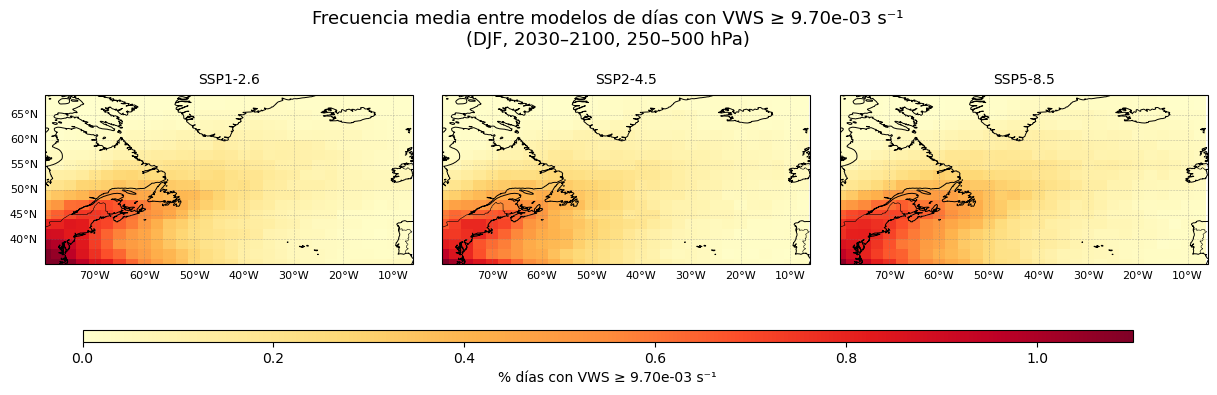

✔ Figura de frecuencias guardada en:
C:\Users\jaime\Desktop\Universidad\TFG\Resultados\Comparaciones\Frecuencia_VWS_SSP126_245_585.png


In [4]:
# PANEL COMPARATIVO DE FRECUENCIAS DE VWS
# Umbral único: 9.7×10⁻³ s⁻¹
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Carpeta de salida
out_dir = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados\Comparaciones"
os.makedirs(out_dir, exist_ok=True)

# CARGA DE DATOS
base_resultados = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados"

# Umbral de VWS (para texto y nombre de archivo)
UMBRAL_VWS = 9.7e-3  # s^-1

# Función para cargar frecuencia de VWS para un escenario
# (usa exactamente el mismo UMBRAL_VWS que en el guardado)
def load_freq(escenario):
    ruta = os.path.join(
        base_resultados, escenario, "CAT index", "por_modelo",
        f"VWS_frecuencia_por_modelo_{escenario}_{UMBRAL_VWS}.nc"
    )
    return xr.open_dataarray(ruta)

# Frecuencias por escenario
vws_frec_126 = load_freq("SSP126")
vws_frec_245 = load_freq("SSP245")
vws_frec_585 = load_freq("SSP585")

# Promedio multimodelo de las frecuencias (%)
vws_frec_126_mean = vws_frec_126.mean("modelo")
vws_frec_245_mean = vws_frec_245.mean("modelo")
vws_frec_585_mean = vws_frec_585.mean("modelo")

# FUNCIÓN PARA DIBUJAR MAPAS DE FRECUENCIAS
def draw_freq(ax, da, title, norm, cmap="YlOrRd", show_left=False, show_bottom=False):
    im = da.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=cmap, norm=norm, add_colorbar=False
    )
    ax.set_title(title, fontsize=10, pad=8)
    ax.coastlines(linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_extent([280, 354, 35, 69], crs=ccrs.PlateCarree())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = show_left
    gl.bottom_labels = show_bottom
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return im

# FUNCIÓN PARA DIBUJAR MAPAS (frecuencias o diferencias)
def draw_map(ax, da, title, norm, cmap="YlOrRd",
             show_left=False, show_bottom=False):
    im = da.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=cmap, norm=norm, add_colorbar=False
    )
    ax.set_title(title, fontsize=10, pad=8)
    ax.coastlines(linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_extent([280, 354, 35, 69], crs=ccrs.PlateCarree())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = show_left
    gl.bottom_labels = show_bottom
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return im

# FIGURA — FRECUENCIA DE VWS PARA UN UMBRAL

freq_norm = mcolors.Normalize(vmin=0, vmax=1.1) # ajusta si ves que se satura

fig, axes = plt.subplots(
    1, 3, figsize=(15, 4),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
ax11, ax12, ax13 = axes

# Fila única: umbral 9.7e-3 s^-1
draw_freq(ax11, vws_frec_126_mean,
          "SSP1-2.6",
          freq_norm, show_left=True, show_bottom=True)
draw_freq(ax12, vws_frec_245_mean,
          "SSP2-4.5",
          freq_norm, show_left=False, show_bottom=True)
draw_freq(ax13, vws_frec_585_mean,
          "SSP5-8.5",
          freq_norm, show_left=False, show_bottom=True)

# BARRA DE COLOR

cbar_ax = fig.add_axes([0.15, 0.12, 0.7, 0.03])  # debajo de los mapas
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=freq_norm, cmap="YlOrRd"),
    cax=cbar_ax, orientation="horizontal"
)
cbar.set_label(f"% días con VWS ≥ {UMBRAL_VWS:.2e} s⁻¹")

# Título y guardado
fig.suptitle(
    f"Frecuencia media entre modelos de días con VWS ≥ {UMBRAL_VWS:.2e} s⁻¹\n"
    "(DJF, 2030–2100, 250–500 hPa)",
    fontsize=13, y=0.95
)
plt.subplots_adjust(top=0.85, bottom=0.20, wspace=0.08)

out_fig = os.path.join(out_dir, "Frecuencia_VWS_SSP126_245_585.png")
fig.savefig(out_fig, dpi=300, bbox_inches="tight")
plt.show()
print(f"Figura de frecuencias guardada en:\n{out_fig}")


In [3]:
import os
import xarray as xr

base_resultados = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados"
UMBRAL_VWS = 9.7e-3

def check_freq(escenario):
    ruta = os.path.join(
        base_resultados, escenario, "CAT index", "por_modelo",
        f"VWS_frecuencia_por_modelo_{escenario}_{UMBRAL_VWS}.nc"
    )
    print("\n======", escenario, "======")
    print("Archivo:", ruta)
    
    da = xr.open_dataarray(ruta)
    print("Dims:", da.dims)

    print("   → Mín =", float(da.min()))
    print("   → Máx =", float(da.max()))
    
    if "modelo" in da.dims:
        print("   → Nº modelos =", len(da.modelo))
        for m in da.modelo.values:
            sub = da.sel(modelo=m)
            print(f"      Modelo {m}: min={float(sub.min()):.3f}, max={float(sub.max()):.3f}")
    else:
        print("No hay dimensión modelo")
        
check_freq("SSP126")
check_freq("SSP245")
check_freq("SSP585")


====== SSP126 ======
Archivo: C:\Users\jaime\Desktop\Universidad\TFG\Resultados\SSP126\CAT index\por_modelo\VWS_frecuencia_por_modelo_SSP126_0.0097.nc
Dims: ('modelo', 'lat', 'lon')
   → Mín = 0.0
   → Máx = 2.7313875448727956
   → Nº modelos = 9
      Modelo IPSL-CM6A-LR: min=0.000, max=0.874
      Modelo HadGEM3-GC31-LL: min=0.000, max=2.379
      Modelo CESM2-WACCM: min=0.000, max=0.548
      Modelo GFDL-CM4: min=0.000, max=1.717
      Modelo MPI-ESM1-2-LR: min=0.000, max=0.626
      Modelo NorESM2-LM: min=0.000, max=2.716
      Modelo ACCESS-CM2: min=0.000, max=2.731
      Modelo EC-Earth3-Veg-LR: min=0.000, max=1.139
      Modelo MIROC6: min=0.000, max=0.391

====== SSP245 ======
Archivo: C:\Users\jaime\Desktop\Universidad\TFG\Resultados\SSP245\CAT index\por_modelo\VWS_frecuencia_por_modelo_SSP245_0.0097.nc
Dims: ('modelo', 'lat', 'lon')
   → Mín = 0.0
   → Máx = 2.5597003277665054
   → Nº modelos = 10
      Modelo IPSL-CM6A-LR: min=0.000, max=0.874
      Modelo HadGEM3-GC31-LL: 

In [4]:
print("\n Comprobando promedio multimodelo")

for escenario, da in zip(
    ["SSP126", "SSP245", "SSP585"],
    [vws_frec_126, vws_frec_245, vws_frec_585]
):
    mean_da = da.mean("modelo")
    print(f"\nEscenario {escenario}:")
    print("  Min =", float(mean_da.min()))
    print("  Max =", float(mean_da.max()))
    print("  Mean global =", float(mean_da.mean()))



=== Comprobando promedio multimodelo ===

Escenario SSP126:
  Min = 0.0
  Max = 1.2705337149039058
  Mean global = 0.18109945697581403

Escenario SSP245:
  Min = 0.0
  Max = 1.1294249027801897
  Mean global = 0.16658610440561838

Escenario SSP585:
  Min = 0.0
  Max = 1.0699902029104025
  Mean global = 0.18300886970560196


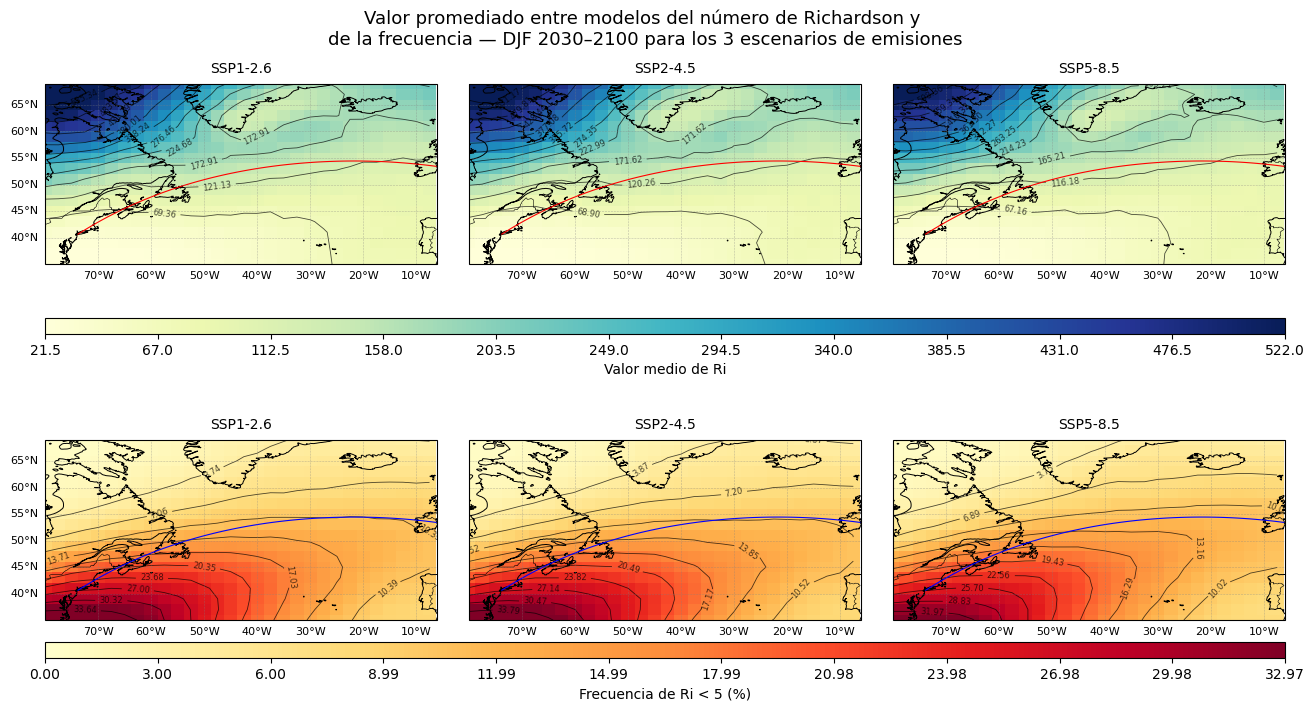

✔ Panel de número de Richardson guardado en:
C:/Users/jaime/Desktop/Universidad/TFG/Resultados\Panel_Richardson_SSP126_245_585.png


In [6]:
# PANEL COMPARATIVO POR ESCENARIO (Número de Richardson)
# Añadido SSP1-2.6 como primera columna
# Directorio base
base_resultados = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados"

# Archivos de RI (media y frecuencia <0.25)
Ri_mean_126 = xr.open_dataarray(os.path.join(base_resultados, "SSP126", "CAT index", "Ri_mean_multimodelo_SSP126.nc"))
Ri_mean_245 = xr.open_dataarray(os.path.join(base_resultados, "SSP245", "CAT index", "Ri_mean_multimodelo_SSP245.nc"))
Ri_mean_585 = xr.open_dataarray(os.path.join(base_resultados, "SSP585", "CAT index", "Ri_mean_multimodelo_SSP585.nc"))

Ri_freq5_126 = xr.open_dataarray(os.path.join(base_resultados, "SSP126", "CAT index", "Ri_freq5_multimodelo_SSP126.nc"))
Ri_freq5_245 = xr.open_dataarray(os.path.join(base_resultados, "SSP245", "CAT index", "Ri_freq5_multimodelo_SSP245.nc"))
Ri_freq5_585 = xr.open_dataarray(os.path.join(base_resultados, "SSP585", "CAT index", "Ri_freq5_multimodelo_SSP585.nc"))
# Escalas comunes (robustas, ahora con 3 escenarios)
ri_vmin = float(xr.concat([Ri_mean_126, Ri_mean_245, Ri_mean_585], dim="merge").quantile(0.02))
ri_vmax = float(xr.concat([Ri_mean_126, Ri_mean_245, Ri_mean_585], dim="merge").quantile(0.98))
ri_norm = mcolors.Normalize(vmin=ri_vmin, vmax=ri_vmax)

freq_vmin = 0
freq_vmax = float(xr.concat([Ri_freq5_126, Ri_freq5_245, Ri_freq5_585], dim="merge").quantile(0.98))
freq_norm = mcolors.Normalize(vmin=freq_vmin, vmax=freq_vmax)

# Figura base (2 filas × 3 columnas)
fig, axes = plt.subplots(
    2, 3, figsize=(16, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
(ax_ri_126, ax_ri_245, ax_ri_585), (ax_freq_126, ax_freq_245, ax_freq_585) = axes

# Función para graficar (idéntica)
def draw_map(ax, da, title, cmap, norm, show_left=False, show_bottom=False, route_color="black"):
    im = da.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=cmap, norm=norm, add_colorbar=False
    )
    # Contornos negros
    n_levels = 12
    levels = np.linspace(float(da.min()), float(da.max()), n_levels)
    cs = ax.contour(
        da.lon, da.lat, da,
        levels=levels,
        colors="black", alpha=0.7, linewidths=0.6,
        transform=ccrs.PlateCarree()
    )
    ax.clabel(cs, fmt="%.2f", fontsize=6, colors="black", inline=True, inline_spacing=3)

    ax.set_title(title, fontsize=10, pad=8)
    ax.coastlines(linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_extent([280, 354, 35, 69], crs=ccrs.PlateCarree())
    ax.plot(lons, lats, transform=ccrs.Geodetic(), color=route_color, linewidth=0.8)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = show_left
    gl.bottom_labels = show_bottom
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return im

# Graficar panel
# Fila 1: Ri medio
im_ri_126 = draw_map(ax_ri_126, Ri_mean_126, "SSP1-2.6", "YlGnBu", ri_norm, show_left=True, show_bottom=True, route_color="red")
im_ri_245 = draw_map(ax_ri_245, Ri_mean_245, "SSP2-4.5", "YlGnBu", ri_norm, show_left=False, show_bottom=True, route_color="red")
im_ri_585 = draw_map(ax_ri_585, Ri_mean_585, "SSP5-8.5", "YlGnBu", ri_norm, show_left=False, show_bottom=True, route_color="red")

# Fila 2: Frecuencia Ri<5
im_freq_126 = draw_map(ax_freq_126, Ri_freq5_126, "SSP1-2.6", "YlOrRd", freq_norm, show_left=True, show_bottom=True, route_color="blue")
im_freq_245 = draw_map(ax_freq_245, Ri_freq5_245, "SSP2-4.5", "YlOrRd", freq_norm, show_left=False, show_bottom=True, route_color="blue")
im_freq_585 = draw_map(ax_freq_585, Ri_freq5_585, "SSP5-8.5", "YlOrRd", freq_norm, show_left=False, show_bottom=True, route_color="blue")

# Barras de color (ajustadas a 3 columnas)
r1 = [ax_ri_126.get_position(), ax_ri_245.get_position(), ax_ri_585.get_position()]
r2 = [ax_freq_126.get_position(), ax_freq_245.get_position(), ax_freq_585.get_position()]

# Barra Ri medio
x0_r1, x1_r1 = min(p.x0 for p in r1), max(p.x1 for p in r1)
y0_r1 = min(p.y0 for p in r1); y1_r2 = max(p.y1 for p in r2)
h_cb1 = 0.020; y_cb1 = (y1_r2 + y0_r1 - h_cb1) / 2.0 + 0.07
cax1 = fig.add_axes([x0_r1, y_cb1, x1_r1 - x0_r1, h_cb1])
cb1 = fig.colorbar(plt.cm.ScalarMappable(norm=ri_norm, cmap="YlGnBu"),
                   cax=cax1, orientation="horizontal")
cb1.set_ticks(np.linspace(ri_vmin, ri_vmax, 12))
cb1.set_label("Valor medio de Ri")

# Barra frecuencia Ri<5
x0_r2, x1_r2 = min(p.x0 for p in r2), max(p.x1 for p in r2)
y0_r2 = min(p.y0 for p in r2)
h_cb2 = 0.020; y_cb2 = max(0.05, y0_r2 - h_cb2 - 0.010)
cax2 = fig.add_axes([x0_r2, y_cb2, x1_r2 - x0_r2, h_cb2])
cb2 = fig.colorbar(plt.cm.ScalarMappable(norm=freq_norm, cmap="YlOrRd"),
                   cax=cax2, orientation="horizontal")
cb2.set_ticks(np.linspace(freq_vmin, freq_vmax, 12))
cb2.set_label("Frecuencia de Ri < 5 (%)")

# Título y guardado
plt.subplots_adjust(top=0.965, bottom=0.10, wspace=0.08, hspace=0.06)
fig.suptitle("Valor promediado entre modelos del número de Richardson y \nde la frecuencia — DJF 2030–2100 para los 3 escenarios de emisiones", fontsize=13, y=0.96)

salida_Ri_panel = os.path.join(BASE_RESULTADOS, "Panel_Richardson_SSP126_245_585.png")
plt.savefig(salida_Ri_panel, dpi=300, bbox_inches="tight")
plt.show()

print(f"Panel de número de Richardson guardado en:\n{salida_Ri_panel}")


✔ Tendencia cargada y filtrada: TA_tendencia_multimodelo_SSP126.nc
✔ Tendencia cargada y filtrada: TA_tendencia_multimodelo_SSP245.nc
✔ Tendencia cargada y filtrada: TA_tendencia_multimodelo_SSP585.nc
✔ TA_media_multimodelo_SSP126.nc abierto correctamente como DataArray
✔ TA_media_multimodelo_SSP245.nc abierto correctamente como DataArray
✔ TA_media_multimodelo_SSP585.nc abierto correctamente como DataArray
📈 Escala común de medias (250 hPa, °C): -60.21 – -49.33 °C
📊 Escala fija de tendencias (250 hPa): 0.0 – 1.0 K/dec


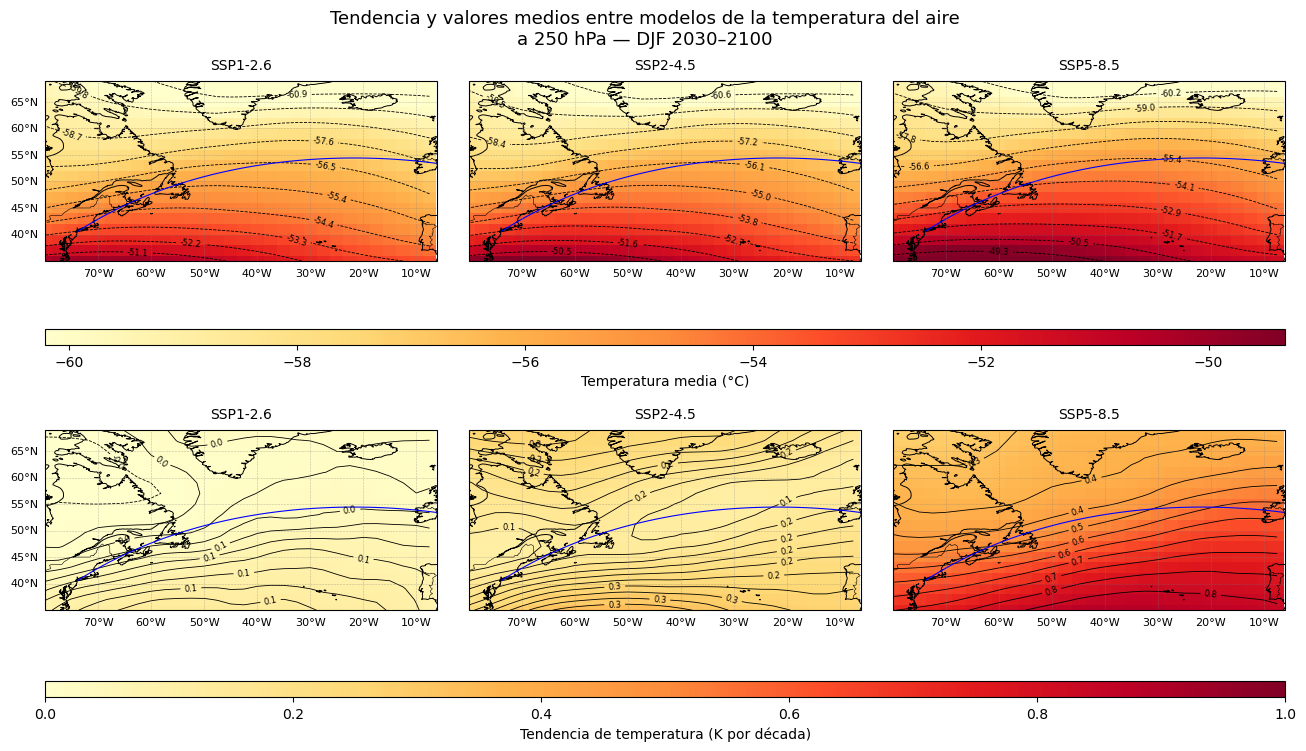

✔ Panel comparativo de TA (°C) guardado en:
C:/Users/jaime/Desktop/Universidad/TFG/Resultados/Comparaciones\Panel_TA_SSP126_245_585_Celsius.png


In [7]:
# PANEL COMPARATIVO MULTIMODELO DE TEMPERATURA (TA)
# Añadido escenario SSP1-2.6
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pyproj import Geod

# CONFIGURACIÓN
BASE_RESULTADOS = "C:/Users/jaime/Desktop/Universidad/TFG/Resultados/Comparaciones"
base_out_126 = "C:/Users/jaime/Desktop/Universidad/TFG/Resultados/SSP126/temperature trends"
base_out_245 = "C:/Users/jaime/Desktop/Universidad/TFG/Resultados/SSP245/temperature trends"
base_out_585 = "C:/Users/jaime/Desktop/Universidad/TFG/Resultados/SSP585/temperature trends"
os.makedirs(BASE_RESULTADOS, exist_ok=True)

# CARGA Y LIMPIEZA
def cargar_tendencia(path_in):
    da = xr.open_dataarray(path_in)
    if "plev" in da.coords:
        da = da.assign_coords(plev=np.round(da["plev"].astype(float), -3))
        da = da.groupby("plev").mean(skipna=True).sortby("plev")
    da = da.where(abs(da) < 1.0)
    print(f"Tendencia cargada y filtrada: {os.path.basename(path_in)}")
    return da

TA_tend_126 = cargar_tendencia(os.path.join(base_out_126, "TA_tendencia_multimodelo_SSP126.nc"))
TA_tend_245 = cargar_tendencia(os.path.join(base_out_245, "TA_tendencia_multimodelo_SSP245.nc"))
TA_tend_585 = cargar_tendencia(os.path.join(base_out_585, "TA_tendencia_multimodelo_SSP585.nc"))

def abrir_dataarray_seguro(path):
    try:
        da = xr.open_dataarray(path, engine="netcdf4")
        print(f"{os.path.basename(path)} abierto correctamente como DataArray")
        return da
    except Exception as e:
        print(f"No se pudo abrir {os.path.basename(path)} como DataArray ({e})")
        ds = xr.open_dataset(path, engine="netcdf4")
        var = list(ds.data_vars)[0]
        print(f"Usando variable: {var}")
        return ds[var]

TA_126 = abrir_dataarray_seguro(os.path.join(base_out_126, "TA_media_multimodelo_SSP126.nc"))
TA_245 = abrir_dataarray_seguro(os.path.join(base_out_245, "TA_media_multimodelo_SSP245.nc"))
TA_585 = abrir_dataarray_seguro(os.path.join(base_out_585, "TA_media_multimodelo_SSP585.nc"))

# Coordenadas DUB–JFK
lon_DUB, lat_DUB = -6.2621, 53.4287
lon_JFK, lat_JFK = -73.7781, 40.6413
geod = Geod(ellps="WGS84")
puntos = geod.npts(lon_DUB, lat_DUB, lon_JFK, lat_JFK, 100)
lons = [lon_DUB] + [p[0] for p in puntos] + [lon_JFK]
lats = [lat_DUB] + [p[1] for p in puntos] + [lat_JFK]

# PREPROCESAMIENTO: seleccionar 250 hPa y promediar
def preparar_ta(da):
    if "plev" in da.coords:
        da = da.assign_coords(plev=da["plev"].astype(float))
        da = da.groupby("plev").mean(skipna=True).sortby("plev")
        da = da.sel(plev=25000, method="nearest")
    if "winter_year" in da.dims:
        da = da.mean("winter_year", skipna=True)
    return da

TA_126_250   = preparar_ta(TA_126)
TA_245_250   = preparar_ta(TA_245)
TA_585_250   = preparar_ta(TA_585)
TA_t126_250  = preparar_ta(TA_tend_126)
TA_t245_250  = preparar_ta(TA_tend_245)
TA_t585_250  = preparar_ta(TA_tend_585)

# ESCALAS ROBUSTAS (250 hPa, en ºC)
# Convertir las temperaturas de K → °C
TA_126_250_C = TA_126_250 - 273.15
TA_245_250_C = TA_245_250 - 273.15
TA_585_250_C = TA_585_250 - 273.15

# Calcular escala común en °C
ta_triplet = xr.concat([TA_126_250_C, TA_245_250_C, TA_585_250_C], dim="merge")
ta_vmin = float(ta_triplet.quantile(0.10))
ta_vmax = float(ta_triplet.quantile(0.99))
ta_norm = mcolors.Normalize(vmin=ta_vmin, vmax=ta_vmax)
print(f"Escala común de medias (250 hPa, °C): {ta_vmin:.2f} – {ta_vmax:.2f} °C")

# Tendencias (mantienen K/dec)
ta_tend_triplet = xr.concat([TA_t126_250, TA_t245_250, TA_t585_250], dim="merge")
ta_tend_vmin = 0.0
ta_tend_vmax = 1.0
ta_tend_norm = mcolors.Normalize(vmin=ta_tend_vmin, vmax=ta_tend_vmax)
print(f"Escala fija de tendencias (250 hPa): {ta_tend_vmin:.1f} – {ta_tend_vmax:.1f} K/dec")


# FUNCIÓN DE DIBUJO
def draw_map(ax, da, title, norm, cmap, show_left=False, show_bottom=False, contorno_color="black"):
    im = da.plot(ax=ax, transform=ccrs.PlateCarree(),
                 cmap=cmap, norm=norm, add_colorbar=False)
    n_contours = 12
    levels = np.linspace(float(da.min()), float(da.max()), n_contours)
    cs = ax.contour(da.lon, da.lat, da, levels=levels,
                    colors=contorno_color, linewidths=0.6, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%.1f", fontsize=6, colors=contorno_color, inline=True, inline_spacing=3)
    ax.set_title(title, fontsize=10, pad=8)
    ax.coastlines(linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_extent([280, 354, 35, 69], crs=ccrs.PlateCarree())
    ax.plot(lons, lats, transform=ccrs.Geodetic(), color="blue", linewidth=0.8)
    gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False; gl.right_labels = False
    gl.left_labels = show_left; gl.bottom_labels = show_bottom
    gl.xlabel_style = {"size": 8}; gl.ylabel_style = {"size": 8}
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    return im

# FIGURA FINAL (2×3)
fig, axes = plt.subplots(2, 3, figsize=(16, 8),
                         subplot_kw={"projection": ccrs.PlateCarree()})
(ax_ta_126, ax_ta_245, ax_ta_585), (ax_tend_126, ax_tend_245, ax_tend_585) = axes

# Fila 1: medias (en °C)
draw_map(ax_ta_126, TA_126_250_C, "SSP1-2.6",
         ta_norm, "YlOrRd", show_left=True, show_bottom=True)
draw_map(ax_ta_245, TA_245_250_C, "SSP2-4.5",
         ta_norm, "YlOrRd", show_bottom=True)
draw_map(ax_ta_585, TA_585_250_C, "SSP5-8.5",
         ta_norm, "YlOrRd", show_bottom=True)

# Fila 2: tendencias (K/dec)
draw_map(ax_tend_126, TA_t126_250, "SSP1-2.6",
         ta_tend_norm, "YlOrRd", show_left=True, show_bottom=True)
draw_map(ax_tend_245, TA_t245_250, "SSP2-4.5",
         ta_tend_norm, "YlOrRd", show_bottom=True)
draw_map(ax_tend_585, TA_t585_250, "SSP5-8.5",
         ta_tend_norm, "YlOrRd", show_bottom=True)

# Colorbars
r1 = [ax_ta_126.get_position(), ax_ta_245.get_position(), ax_ta_585.get_position()]
cax1 = fig.add_axes([min(p.x0 for p in r1), min(p.y0 for p in r1) - 0.05,
                     max(p.x1 for p in r1) - min(p.x0 for p in r1), 0.02])
fig.colorbar(plt.cm.ScalarMappable(norm=ta_norm, cmap="YlOrRd"),
             cax=cax1, orientation="horizontal", label="Temperatura media (°C)")

r2 = [ax_tend_126.get_position(), ax_tend_245.get_position(), ax_tend_585.get_position()]
cax2 = fig.add_axes([min(p.x0 for p in r2), min(p.y0 for p in r2) - 0.07,
                     max(p.x1 for p in r2) - min(p.x0 for p in r2), 0.02])
fig.colorbar(plt.cm.ScalarMappable(norm=ta_tend_norm, cmap="YlOrRd"),
             cax=cax2, orientation="horizontal", label="Tendencia de temperatura (K por década)")

# Ajustes finales
plt.subplots_adjust(top=0.95, bottom=0.15, wspace=0.08, hspace=0.20)
fig.suptitle("Tendencia y valores medios entre modelos de la temperatura del aire\na 250 hPa — DJF 2030–2100", fontsize=13, y=0.97)

salida_panel = os.path.join(BASE_RESULTADOS, "Panel_TA_SSP126_245_585_Celsius.png")
plt.savefig(salida_panel, dpi=300, bbox_inches="tight")
plt.show()
print(f"Panel comparativo de TA (°C) guardado en:\n{salida_panel}")

✔ gradT_media_multimodelo_SSP126.nc abierto correctamente como DataArray
✔ gradT_media_multimodelo_SSP245.nc abierto correctamente como DataArray
✔ gradT_media_multimodelo_SSP585.nc abierto correctamente como DataArray
📈 Escala común |∇H T| (K m-1): 2.05e-06 – 5.33e-06


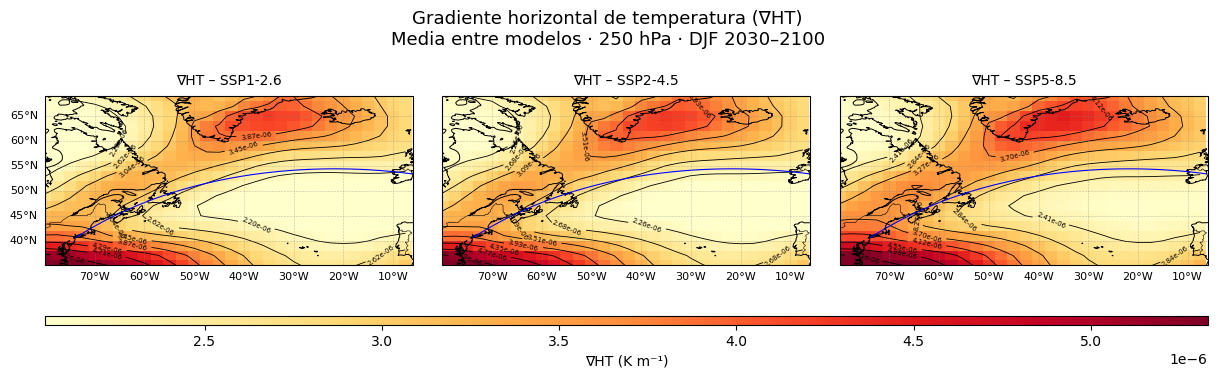

✔ Panel comparativo de |∇HT| (solo medias) guardado en:
C:/Users/jaime/Desktop/Universidad/TFG/Resultados/Comparaciones\Panel_gradT_multimodelo_SSP126_245_585_solo_medias.png


In [8]:
# PANEL MULTIMODELO DEL GRADIENTE HORIZONTAL DE TEMPERATURA (|∇H T|)
# Usando gradT_media_multimodelo_<escenario>.nc
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pyproj import Geod

# CONFIGURACIÓN
BASE_RESULTADOS = "C:/Users/jaime/Desktop/Universidad/TFG/Resultados/Comparaciones"
base_out_126 = "C:/Users/jaime/Desktop/Universidad/TFG/Resultados/SSP126/temperature trends"
base_out_245 = "C:/Users/jaime/Desktop/Universidad/TFG/Resultados/SSP245/temperature trends"
base_out_585 = "C:/Users/jaime/Desktop/Universidad/TFG/Resultados/SSP585/temperature trends"
os.makedirs(BASE_RESULTADOS, exist_ok=True)

# CARGA
def abrir_dataarray_seguro(path):
    try:
        da = xr.open_dataarray(path, engine="netcdf4")
        print(f"{os.path.basename(path)} abierto correctamente como DataArray")
        return da
    except Exception as e:
        print(f"No se pudo abrir {os.path.basename(path)} como DataArray ({e})")
        ds = xr.open_dataset(path, engine="netcdf4")
        var = list(ds.data_vars)[0]
        print(f"Usando variable: {var}")
        return ds[var]

gradT_126 = abrir_dataarray_seguro(os.path.join(base_out_126, "gradT_media_multimodelo_SSP126.nc"))
gradT_245 = abrir_dataarray_seguro(os.path.join(base_out_245, "gradT_media_multimodelo_SSP245.nc"))
gradT_585 = abrir_dataarray_seguro(os.path.join(base_out_585, "gradT_media_multimodelo_SSP585.nc"))

# Coordenadas DUB–JFK
lon_DUB, lat_DUB = -6.2621, 53.4287
lon_JFK, lat_JFK = -73.7781, 40.6413
geod = Geod(ellps="WGS84")
puntos = geod.npts(lon_DUB, lat_DUB, lon_JFK, lat_JFK, 100)
lons = [lon_DUB] + [p[0] for p in puntos] + [lon_JFK]
lats = [lat_DUB] + [p[1] for p in puntos] + [lat_JFK]

# ESCALA COMÚN PARA |∇H T|
grad_triplet = xr.concat([gradT_126, gradT_245, gradT_585], dim="merge")
g_vmin = float(grad_triplet.quantile(0.10))
g_vmax = float(grad_triplet.quantile(0.99))
grad_norm = mcolors.Normalize(vmin=g_vmin, vmax=g_vmax)
print(f"Escala común |∇H T| (K m-1): {g_vmin:.2e} – {g_vmax:.2e}")

# FUNCIÓN DE DIBUJO
def draw_map(ax, da, title, norm, cmap, show_left=False, show_bottom=False, contorno_color="black"):
    im = da.plot(ax=ax, transform=ccrs.PlateCarree(),
                 cmap=cmap, norm=norm, add_colorbar=False)
    n_contours = 10
    levels = np.linspace(float(da.min()), float(da.max()), n_contours)
    cs = ax.contour(da.lon, da.lat, da, levels=levels,
                    colors=contorno_color, linewidths=0.6,
                    transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%.2e", fontsize=5, colors=contorno_color,
              inline=True, inline_spacing=3)
    ax.set_title(title, fontsize=10, pad=8)
    ax.coastlines(linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_extent([280, 354, 35, 69], crs=ccrs.PlateCarree())
    ax.plot(lons, lats, transform=ccrs.Geodetic(), color="blue", linewidth=0.8)

    gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray',
                      alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = show_left
    gl.bottom_labels = show_bottom
    gl.xlabel_style = {"size": 8}
    gl.ylabel_style = {"size": 8}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return im

# FIGURA FINAL (1×3)
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5),
                         subplot_kw={"projection": ccrs.PlateCarree()})
ax_g_126, ax_g_245, ax_g_585 = axes

draw_map(ax_g_126, gradT_126,
         "∇HT – SSP1-2.6",
         grad_norm, "YlOrRd", show_left=True, show_bottom=True)

draw_map(ax_g_245, gradT_245,
         "∇HT – SSP2-4.5",
         grad_norm, "YlOrRd", show_bottom=True)

draw_map(ax_g_585, gradT_585,
         "∇HT – SSP5-8.5",
         grad_norm, "YlOrRd", show_bottom=True)

# Colorbar común
r1 = [ax_g_126.get_position(), ax_g_245.get_position(), ax_g_585.get_position()]
cax1 = fig.add_axes([min(p.x0 for p in r1),
                     min(p.y0 for p in r1) - 0.08,
                     max(p.x1 for p in r1) - min(p.x0 for p in r1),
                     0.02])

fig.colorbar(plt.cm.ScalarMappable(norm=grad_norm, cmap="YlOrRd"),
             cax=cax1, orientation="horizontal",
             label="∇HT (K m⁻¹)")

plt.subplots_adjust(top=0.90, bottom=0.22, wspace=0.08)
fig.suptitle("Gradiente horizontal de temperatura (∇HT)\n"
             "Media entre modelos · 250 hPa · DJF 2030–2100",
             fontsize=13, y=0.94)

salida_panel = os.path.join(BASE_RESULTADOS, "Panel_gradT_multimodelo_SSP126_245_585_solo_medias.png")
plt.savefig(salida_panel, dpi=300, bbox_inches="tight")
plt.show()
print(f"Panel comparativo de |∇HT| (solo medias) guardado en:\n{salida_panel}")


🔧 Límite global barras TA: ±1.00 K por década


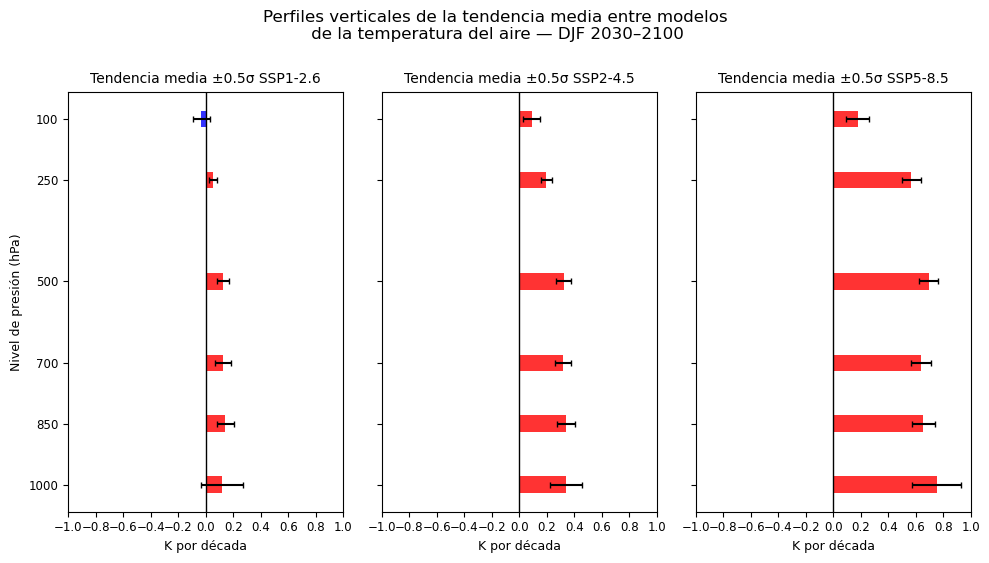

✔ Figura multimodelo TA (barras 3 escenarios) guardada en:
C:\Users\jaime\Desktop\Universidad\TFG\Resultados\Comparaciones\perfiles_multimodelo_barras_TA_tendencia_SSP126_245_585.png


In [9]:
# BARRAS DE TEMPERATURA (TA)
# PERFILES VERTICALES MULTIMODELO (BARRAS + ERROR)
#      PARA SSP1-2.6, SSP2-4.5 Y SSP5-8.5

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
import pandas as pd
import xarray as xr

# Rutas de entrada
base_out_126 = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados\SSP126\temperature trends"
base_out_245 = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados\SSP245\temperature trends"
base_out_585 = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados\SSP585\temperature trends"

# Cargar archivos multimodelo
TA_tend_126 = xr.open_dataarray(os.path.join(base_out_126, "TA_tendencias_por_modelo_SSP126.nc"))
TA_tend_245 = xr.open_dataarray(os.path.join(base_out_245, "TA_tendencias_por_modelo_SSP245.nc"))
TA_tend_585 = xr.open_dataarray(os.path.join(base_out_585, "TA_tendencias_por_modelo_SSP585.nc"))

# Función para media multimodelo + desviación
def perfil_media_y_sigma(da):
    """
    Calcula el perfil vertical multimodelo de tendencia de temperatura:
    - Media multimodelo punto a punto (mantiene estructura espacial).
    - σ entre modelos (dispersión entre ellos).
    - Luego promedio global (lat/lon) con peso cos(lat).
    """

    da = da.assign_coords(plev=da["plev"].astype(float))

    # Media multimodelo punto a punto y desviación
    da_mm = da.mean(dim="modelo", skipna=True)
    da_std = da.std(dim="modelo", skipna=True, ddof=1)

    # Media espacial ponderada por cos(lat)
    dims_espaciales = [d for d in da_mm.dims if d not in ("plev",)]
    if "lat" in da_mm.dims:
        weights = np.cos(np.deg2rad(da_mm.lat))
        da_mm_global  = da_mm.weighted(weights).mean(dim=dims_espaciales)
        da_std_global = da_std.weighted(weights).mean(dim=dims_espaciales)
    else:
        da_mm_global  = da_mm.mean(dim=dims_espaciales)
        da_std_global = da_std.mean(dim=dims_espaciales)
        
    # Pasar presión a hPa
    plev_vals = da_mm_global["plev"].values
    plev_hpa = np.where(plev_vals > 2000, plev_vals / 100.0, plev_vals)

    # Agrupar por nivel redondeado
    df = pd.DataFrame({
        "plev": np.round(plev_hpa, 0),
        "val": da_mm_global.values.flatten(),
        "err": da_std_global.values.flatten()
    })
    df = df.groupby("plev", as_index=False).mean().sort_values("plev", ascending=False)

    # Reducir a ±0.5σ para claridad visual
    df["err"] = 0.5 * df["err"]

    return df["plev"].values, df["val"].values, df["err"].values

# Obtener perfiles para cada escenario
plev_126, ta_vals_126, ta_err_126 = perfil_media_y_sigma(TA_tend_126)
plev_245, ta_vals_245, ta_err_245 = perfil_media_y_sigma(TA_tend_245)
plev_585, ta_vals_585, ta_err_585 = perfil_media_y_sigma(TA_tend_585)

# Asegurar errores positivos
ta_err_126 = np.abs(ta_err_126)
ta_err_245 = np.abs(ta_err_245)
ta_err_585 = np.abs(ta_err_585)

# Límite global del eje X (K por década)
max_126 = np.nanmax(np.abs(ta_vals_126) + ta_err_126)
max_245 = np.nanmax(np.abs(ta_vals_245) + ta_err_245)
max_585 = np.nanmax(np.abs(ta_vals_585) + ta_err_585)
lim_global_barras_ta = float(np.nanmax([max_126, max_245, max_585]))
lim_global_barras_ta = np.ceil(lim_global_barras_ta * 10) / 10.0  # redondeo a 0.1

print(f"Límite global barras TA: ±{lim_global_barras_ta:.2f} K por década")

# Función para dibujar perfil
def dibujar_perfil_barras_ta(ax, plev, vals, errs, titulo):
    colors = np.where(vals > 0, "red", "blue")
    height = 40  # hPa

    ax.barh(
        plev, vals,
        xerr=errs,               # barras de error = ±0.5σ entre modelos
        color=colors,
        height=height,
        ecolor="k",
        capsize=2,
        alpha=0.8,
    )

    ax.axvline(0, color="k", linewidth=1)
    ax.invert_yaxis()

    ax.set_yticks(plev)
    ax.set_yticklabels(plev.astype(int))
    ax.set_xlabel("K por década", fontsize=9)
    ax.set_title(titulo, fontsize=10)

    ax.set_xlim(-lim_global_barras_ta, lim_global_barras_ta)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.2))
    ax.tick_params(axis="both", which="major", labelsize=8.5)

# Figura 1×3 con los tres escenarios
fig, axes = plt.subplots(1, 3, figsize=(10, 6), sharey=True)

dibujar_perfil_barras_ta(
    axes[0], plev_126, ta_vals_126, ta_err_126,
    "Tendencia media ±0.5σ SSP1-2.6"
)
dibujar_perfil_barras_ta(
    axes[1], plev_245, ta_vals_245, ta_err_245,
    "Tendencia media ±0.5σ SSP2-4.5"
)
dibujar_perfil_barras_ta(
    axes[2], plev_585, ta_vals_585, ta_err_585,
    "Tendencia media ±0.5σ SSP5-8.5"
)

axes[0].set_ylabel("Nivel de presión (hPa)", fontsize=9)

fig.suptitle("Perfiles verticales de la tendencia media entre modelos\n de la temperatura del aire — DJF 2030–2100",
             fontsize=12, y=0.95)

plt.tight_layout(rect=[0, 0.02, 1, 0.95])

# Guardar figura
BASE_RESULTADOS = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados\Comparaciones"
out_file_ta = os.path.join(
    BASE_RESULTADOS, "perfiles_multimodelo_barras_TA_tendencia_SSP126_245_585.png"
)
fig.savefig(out_file_ta, bbox_inches="tight", dpi=300)
plt.show()

print(f"Figura multimodelo TA (barras 3 escenarios) guardada en:\n{out_file_ta}")



✔ Tendencia cargada y filtrada: UA_tendencia_multimodelo_SSP126.nc
✔ Tendencia cargada y filtrada: UA_tendencia_multimodelo_SSP245.nc
✔ Tendencia cargada y filtrada: UA_tendencia_multimodelo_SSP585.nc
✔ UA_media_multimodelo_SSP126.nc abierto correctamente como DataArray
✔ UA_media_multimodelo_SSP245.nc abierto correctamente como DataArray
✔ UA_media_multimodelo_SSP585.nc abierto correctamente como DataArray
📈 Escala común de viento medio (250 hPa): 5.40 – 43.58 m/s
📊 Escala fija de tendencias (250 hPa): -0.7 – 0.7 m/s por década


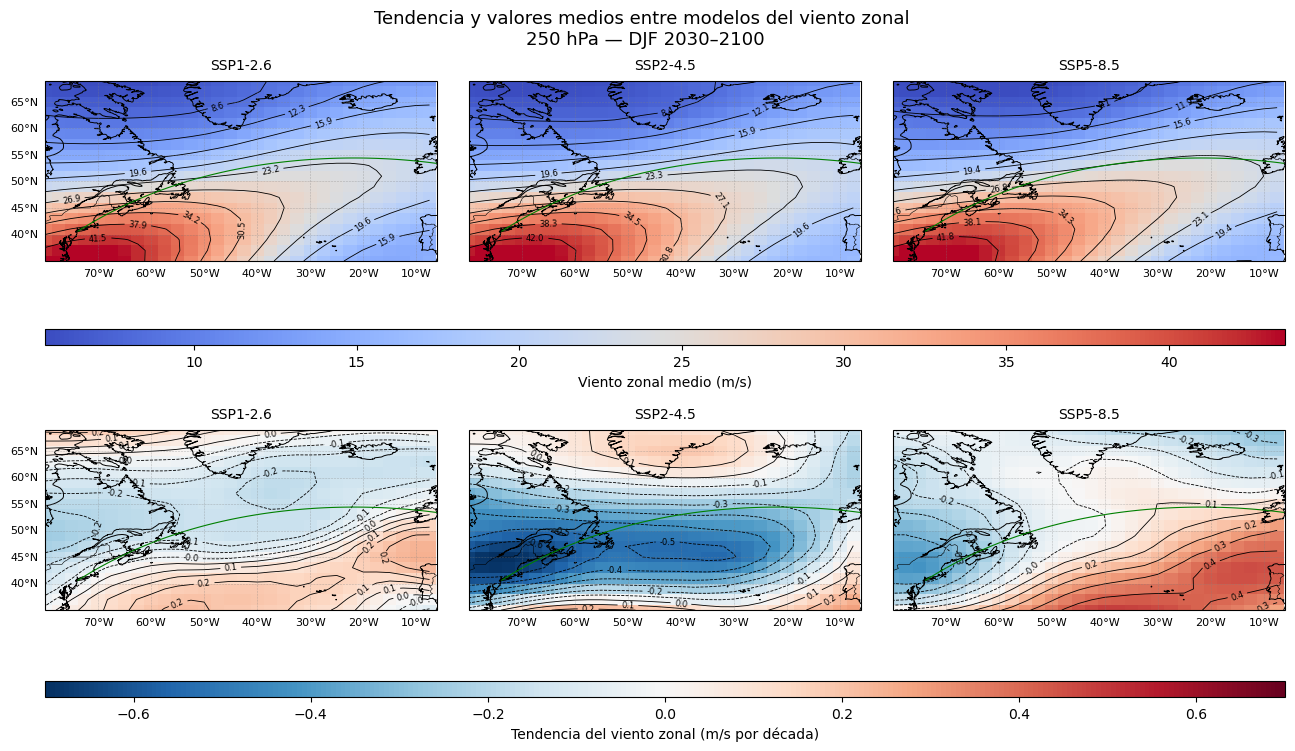

✔ Panel comparativo de UA guardado en:
C:/Users/jaime/Desktop/Universidad/TFG/Resultados/Comparaciones\Panel_UA_SSP126_245_585.png


In [10]:
# PANEL COMPARATIVO MULTIMODELO DE VIENTO ZONAL (UA)
# Añadido escenario SSP1-2.6

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pyproj import Geod

# CONFIGURACIÓN
BASE_RESULTADOS = "C:/Users/jaime/Desktop/Universidad/TFG/Resultados/Comparaciones"
base_out_126 = "C:/Users/jaime/Desktop/Universidad/TFG/Resultados/SSP126/zonal wind"
base_out_245 = "C:/Users/jaime/Desktop/Universidad/TFG/Resultados/SSP245/zonal wind"
base_out_585 = "C:/Users/jaime/Desktop/Universidad/TFG/Resultados/SSP585/zonal wind"
os.makedirs(BASE_RESULTADOS, exist_ok=True)

# CARGA Y LIMPIEZA EN MEMORIA (sin escribir archivos)
def cargar_tendencia(path_in):
    """Carga el NetCDF, filtra valores extremos y devuelve el DataArray."""
    da = xr.open_dataarray(path_in)
    if "plev" in da.coords:
        da = da.assign_coords(plev=np.round(da["plev"].astype(float), -3))
        da = da.groupby("plev").mean(skipna=True).sortby("plev")
    da = da.where(abs(da) < 10.0)
    print(f"Tendencia cargada y filtrada: {os.path.basename(path_in)}")
    return da

UA_tend_126 = cargar_tendencia(os.path.join(base_out_126, "UA_tendencia_multimodelo_SSP126.nc"))
UA_tend_245 = cargar_tendencia(os.path.join(base_out_245, "UA_tendencia_multimodelo_SSP245.nc"))
UA_tend_585 = cargar_tendencia(os.path.join(base_out_585, "UA_tendencia_multimodelo_SSP585.nc"))

# CARGA DE DATOS DE VIENTO ZONAL MEDIO
def abrir_dataarray_seguro(path):
    try:
        da = xr.open_dataarray(path, engine="netcdf4")
        print(f"{os.path.basename(path)} abierto correctamente como DataArray")
        return da
    except Exception as e:
        print(f"No se pudo abrir {os.path.basename(path)} como DataArray ({e})")
        ds = xr.open_dataset(path, engine="netcdf4")
        print(f"Variables disponibles: {list(ds.data_vars)}")
        var = list(ds.data_vars)[0]
        print(f"Usando variable: {var}")
        return ds[var]

UA_126 = abrir_dataarray_seguro(os.path.join(base_out_126, "UA_media_multimodelo_SSP126.nc"))
UA_245 = abrir_dataarray_seguro(os.path.join(base_out_245, "UA_media_multimodelo_SSP245.nc"))
UA_585 = abrir_dataarray_seguro(os.path.join(base_out_585, "UA_media_multimodelo_SSP585.nc"))

# Coordenadas DUB–JFK (trayectoria de corriente en chorro atlántica)
lon_DUB, lat_DUB = -6.2621, 53.4287
lon_JFK, lat_JFK = -73.7781, 40.6413
geod = Geod(ellps="WGS84")
puntos = geod.npts(lon_DUB, lat_DUB, lon_JFK, lat_JFK, 100)
lons = [lon_DUB] + [p[0] for p in puntos] + [lon_JFK]
lats = [lat_DUB] + [p[1] for p in puntos] + [lat_JFK]

# PREPROCESAMIENTO: seleccionar 250 hPa y promediar
def preparar_ua(da):
    if "plev" in da.coords:
        da = da.assign_coords(plev=da["plev"].astype(float))
        da = da.groupby("plev").mean(skipna=True).sortby("plev")
        da = da.sel(plev=25000, method="nearest")
    if "winter_year" in da.dims:
        da = da.mean("winter_year", skipna=True)
    return da

UA_126_250   = preparar_ua(UA_126)
UA_245_250   = preparar_ua(UA_245)
UA_585_250   = preparar_ua(UA_585)
UA_t126_250  = preparar_ua(UA_tend_126)
UA_t245_250  = preparar_ua(UA_tend_245)
UA_t585_250  = preparar_ua(UA_tend_585)

# ESCALAS ROBUSTAS (250 hPa)
ua_triplet = xr.concat([UA_126_250, UA_245_250, UA_585_250], dim="merge")
ua_vmin = float(ua_triplet.quantile(0.02))
ua_vmax = float(ua_triplet.quantile(0.98))
ua_norm = mcolors.Normalize(vmin=ua_vmin, vmax=ua_vmax)
print(f"Escala común de viento medio (250 hPa): {ua_vmin:.2f} – {ua_vmax:.2f} m/s")

ua_tend_vmin = -0.7
ua_tend_vmax = 0.7
ua_tend_norm = mcolors.TwoSlopeNorm(vmin=ua_tend_vmin, vcenter=0, vmax=ua_tend_vmax)
print(f"Escala fija de tendencias (250 hPa): {ua_tend_vmin:.1f} – {ua_tend_vmax:.1f} m/s por década")

# FUNCIÓN DE DIBUJO
def draw_map(ax, da, title, norm, cmap, show_left=False, show_bottom=False, contorno_color="black"):
    im = da.plot(ax=ax, transform=ccrs.PlateCarree(),
                 cmap=cmap, norm=norm, add_colorbar=False)
    n_contours = 12
    levels = np.linspace(float(da.min()), float(da.max()), n_contours)
    cs = ax.contour(da.lon, da.lat, da, levels=levels,
                    colors=contorno_color, linewidths=0.6, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%.1f", fontsize=6, colors=contorno_color, inline=True, inline_spacing=3)
    ax.set_title(title, fontsize=10, pad=8)
    ax.coastlines(linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_extent([280, 354, 35, 69], crs=ccrs.PlateCarree())
    ax.plot(lons, lats, transform=ccrs.Geodetic(), color="green", linewidth=0.8)
    gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False; gl.right_labels = False
    gl.left_labels = show_left; gl.bottom_labels = show_bottom
    gl.xlabel_style = {"size": 8}; gl.ylabel_style = {"size": 8}
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    return im

# FIGURA FINAL (2 × 3)
fig, axes = plt.subplots(2, 3, figsize=(16, 8),
                         subplot_kw={"projection": ccrs.PlateCarree()})
(ax_ua_126, ax_ua_245, ax_ua_585), (ax_tend_126, ax_tend_245, ax_tend_585) = axes

# Fila 1: viento zonal medio
draw_map(ax_ua_126, UA_126_250, "SSP1-2.6",
         ua_norm, "coolwarm", show_left=True, show_bottom=True)
draw_map(ax_ua_245, UA_245_250, "SSP2-4.5",
         ua_norm, "coolwarm", show_bottom=True)
draw_map(ax_ua_585, UA_585_250, "SSP5-8.5",
         ua_norm, "coolwarm", show_bottom=True)

# Fila 2: tendencias
draw_map(ax_tend_126, UA_t126_250, "SSP1-2.6",
         ua_tend_norm, "RdBu_r", show_left=True, show_bottom=True)
draw_map(ax_tend_245, UA_t245_250, "SSP2-4.5",
         ua_tend_norm, "RdBu_r", show_bottom=True)
draw_map(ax_tend_585, UA_t585_250, "SSP5-8.5",
         ua_tend_norm, "RdBu_r", show_bottom=True)

# Colorbars
r1 = [ax_ua_126.get_position(), ax_ua_245.get_position(), ax_ua_585.get_position()]
cax1 = fig.add_axes([min(p.x0 for p in r1), min(p.y0 for p in r1) - 0.05,
                     max(p.x1 for p in r1) - min(p.x0 for p in r1), 0.02])
fig.colorbar(plt.cm.ScalarMappable(norm=ua_norm, cmap="coolwarm"),
             cax=cax1, orientation="horizontal", label="Viento zonal medio (m/s)")

r2 = [ax_tend_126.get_position(), ax_tend_245.get_position(), ax_tend_585.get_position()]
cax2 = fig.add_axes([min(p.x0 for p in r2), min(p.y0 for p in r2) - 0.07,
                     max(p.x1 for p in r2) - min(p.x0 for p in r2), 0.02])
fig.colorbar(plt.cm.ScalarMappable(norm=ua_tend_norm, cmap="RdBu_r"),
             cax=cax2, orientation="horizontal", label="Tendencia del viento zonal (m/s por década)")

# Ajustes finales
plt.subplots_adjust(top=0.95, bottom=0.15, wspace=0.08, hspace=0.20)
fig.suptitle("Tendencia y valores medios entre modelos del viento zonal \n250 hPa — DJF 2030–2100", fontsize=13, y=0.97)

salida_panel = os.path.join(BASE_RESULTADOS, "Panel_UA_SSP126_245_585.png")
plt.savefig(salida_panel, dpi=300, bbox_inches="tight")
plt.show()
print(f"Panel comparativo de UA guardado en:\n{salida_panel}")


🔧 Límite global barras UA: ±0.70 m/s por década


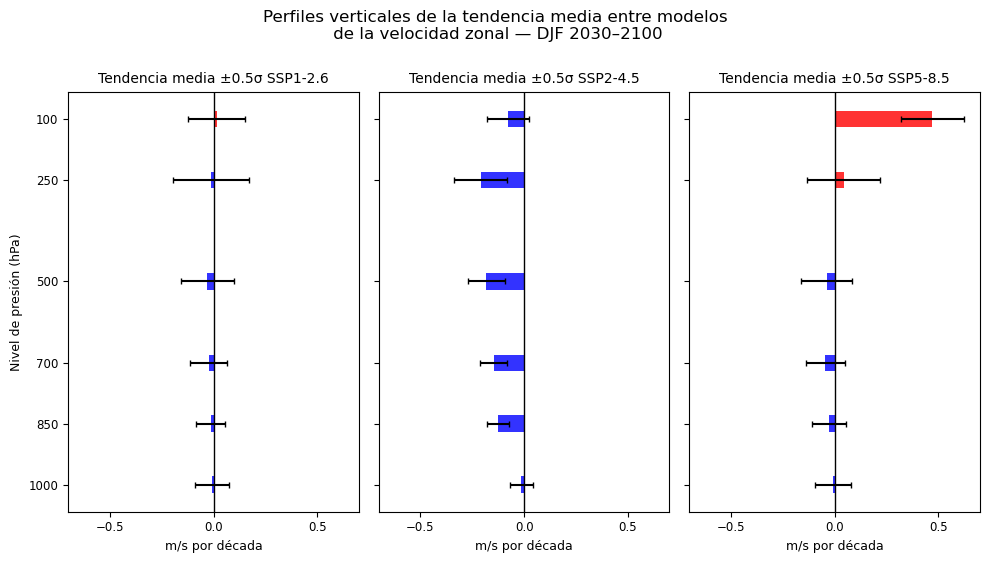

✔ Figura multimodelo UA (barras 3 escenarios) guardada en:
C:/Users/jaime/Desktop/Universidad/TFG/Resultados/Comparaciones\perfiles_multimodelo_barras_UA_tendencia_SSP126_245_585.png


In [11]:
# BARRAS DE VIENTO ZONAL (UA)
# PERFILES VERTICALES MULTIMODELO (BARRAS + ERROR)
#      PARA SSP1-2.6, SSP2-4.5 Y SSP5-8.5

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
import pandas as pd   
import xarray as xr

base_out_126 = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados\SSP126\zonal wind"
base_out_245 = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados\SSP245\zonal wind"
base_out_585 = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados\SSP585\zonal wind"

# ahora se usan los archivos *por modelo*
UA_tend_126 = xr.open_dataarray(os.path.join(base_out_126, "UA_tendencias_por_modelo_SSP126.nc"))
UA_tend_245 = xr.open_dataarray(os.path.join(base_out_245, "UA_tendencias_por_modelo_SSP245.nc"))
UA_tend_585 = xr.open_dataarray(os.path.join(base_out_585, "UA_tendencias_por_modelo_SSP585.nc"))

def perfil_media_y_sigma(da):
    # da: ('modelo', 'plev', 'lat', 'lon')

    da = da.assign_coords(plev=da["plev"].astype(float))

    # Media multimodelo primero (por punto)
    da_mm = da.mean(dim="modelo", skipna=True)
    da_std = da.std(dim="modelo", skipna=True, ddof=1)

    # Media espacial ponderada por cos(lat)
    dims_espaciales = [d for d in da_mm.dims if d not in ("plev",)]
    if "lat" in da_mm.dims:
        weights = np.cos(np.deg2rad(da_mm.lat))
        da_mm_global  = da_mm.weighted(weights).mean(dim=dims_espaciales)
        da_std_global = da_std.weighted(weights).mean(dim=dims_espaciales)
    else:
        da_mm_global  = da_mm.mean(dim=dims_espaciales)
        da_std_global = da_std.mean(dim=dims_espaciales)

    # Convertir presión a hPa y agrupar
    plev_vals = da_mm_global["plev"].values
    plev_hpa = np.where(plev_vals > 2000, plev_vals / 100.0, plev_vals)

    df = pd.DataFrame({
        "plev": np.round(plev_hpa, 0),
        "val": da_mm_global.values.flatten(),
        "err": da_std_global.values.flatten()
    })
    df = df.groupby("plev", as_index=False).mean().sort_values("plev", ascending=False)

    # Reducir a ±0.5σ para claridad visual
    df["err"] = 0.5 * df["err"]

    return df["plev"].values, df["val"].values, df["err"].values

# Obtener perfiles para cada escenario (UA)
plev_126, ua_vals_126, ua_err_126 = perfil_media_y_sigma(UA_tend_126)
plev_245, ua_vals_245, ua_err_245 = perfil_media_y_sigma(UA_tend_245)
plev_585, ua_vals_585, ua_err_585 = perfil_media_y_sigma(UA_tend_585)

# Asegurar errores positivos
ua_err_126 = np.abs(ua_err_126)
ua_err_245 = np.abs(ua_err_245)
ua_err_585 = np.abs(ua_err_585)

# Límite global del eje X (m/s por década)
max_126 = np.nanmax(np.abs(ua_vals_126) + ua_err_126)
max_245 = np.nanmax(np.abs(ua_vals_245) + ua_err_245)
max_585 = np.nanmax(np.abs(ua_vals_585) + ua_err_585)
lim_global_barras_ua = float(np.nanmax([max_126, max_245, max_585]))
lim_global_barras_ua = np.ceil(lim_global_barras_ua * 10) / 10.0  # redondeo a 0.1

print(f"Límite global barras UA: ±{lim_global_barras_ua:.2f} m/s por década")

# Función para dibujar un perfil en un eje concreto
def dibujar_perfil_barras_ua(ax, plev, vals, errs, titulo):
    # Color de la barra por signo de la media multimodelo
    colors = np.where(vals > 0, "red", "blue")
    height = 40  # hPa

    ax.barh(
        plev, vals,
        xerr=errs,               # barras de error = ±1σ entre modelos
        color=colors,
        height=height,
        ecolor="k",
        capsize=2,
        alpha=0.8,
    )

    ax.axvline(0, color="k", linewidth=1)
    ax.invert_yaxis()

    ax.set_yticks(plev)
    ax.set_yticklabels(plev.astype(int))
    ax.set_xlabel("m/s por década", fontsize=9)
    ax.set_title(titulo, fontsize=10)

    ax.set_xlim(-lim_global_barras_ua, lim_global_barras_ua)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.5))
    ax.tick_params(axis="both", which="major", labelsize=8.5)

# Figura 1×3 con los tres escenarios 
fig, axes = plt.subplots(1, 3, figsize=(10, 6), sharey=True)

dibujar_perfil_barras_ua(
    axes[0], plev_126, ua_vals_126, ua_err_126,
    "Tendencia media ±0.5σ SSP1-2.6"
)
dibujar_perfil_barras_ua(
    axes[1], plev_245, ua_vals_245, ua_err_245,
    "Tendencia media ±0.5σ SSP2-4.5"
)
dibujar_perfil_barras_ua(
    axes[2], plev_585, ua_vals_585, ua_err_585,
    "Tendencia media ±0.5σ SSP5-8.5"
)

axes[0].set_ylabel("Nivel de presión (hPa)", fontsize=9)

fig.suptitle("Perfiles verticales de la tendencia media entre modelos\n de la velocidad zonal — DJF 2030–2100",
             fontsize=12, y=0.95)

plt.tight_layout(rect=[0, 0.02, 1, 0.95])

out_file_ua = os.path.join(
    BASE_RESULTADOS, "perfiles_multimodelo_barras_UA_tendencia_SSP126_245_585.png"
)
fig.savefig(out_file_ua, bbox_inches="tight", dpi=300)
plt.show()

print(f"Figura multimodelo UA (barras 3 escenarios) guardada en:\n{out_file_ua}")